# Robustness Issues in Federated Learning

## The setting for running the federated learning is the same as the task0.

In [1]:
# Install dependencies if you don't have them already
!pip install -q flwr[simulation] torch torchvision matplotlib
!pip install tensorflow-gpu==2.8.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 219.2/219.2 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 MB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 497.6/497.6 MB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 102.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.5/462.5 kB 53.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 87.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 107.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 77.3 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.14.0
    Uninstalling keras-2.14.0:
      Successfully uninstalled keras-2.14.0
  Attempting uninstall: tensorboard-data

In [2]:
from collections import OrderedDict
from typing import Dict, List, Optional, Tuple
import matplotlib.pyplot as plt

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import CIFAR10

import flwr as fl
from flwr.common import Metrics
from collections import OrderedDict
from typing import Dict, List, Optional, Tuple
import matplotlib.pyplot as plt

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import CIFAR10

import flwr as fl
from flwr.common import Metrics
from typing import Union

from flwr.common import (
    FitRes,
    Parameters,
    Scalar,
    ndarrays_to_parameters,
    parameters_to_ndarrays,
)
from flwr.server.client_proxy import ClientProxy
from flwr.server.strategy.aggregate import (
    aggregate_median,
)


In [3]:

## Define the setting for FL
NUM_CLIENTS = 10  # Number of clients
LOCAL_EPOCH = 1 # Number of local epochs
NUM_ROUND = 5 # Number of rounds
NUM_ADVERSARY = 1 # Number of malicious clients


ADVERSARY_CID = [i for i in range(NUM_ADVERSARY)] # client id of the adversary

DEVICE = torch.device("cuda")  # Try "cuda" to train on GPU
print(
    f"Training on {DEVICE} using PyTorch {torch.__version__} and Flower {fl.__version__}"
)

# Specify client resources if you need GPU (defaults to 1 CPU and 0 GPU)
client_resources = {"num_cpus": 1}
if DEVICE.type == "cuda":
    client_resources = {"num_gpus": 1, "num_cpus": 1}



Training on cuda using PyTorch 2.1.0+cu118 and Flower 1.6.0


Define helper functions to setup the FL environment and run the FL training process. This functions are explained in Task 0.

In [4]:
def load_datasets(num_clients: int):
    # Download and transform CIFAR-10 (train and test)
    transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )
    trainset = CIFAR10("./dataset", train=True, download=True, transform=transform)
    testset = CIFAR10("./dataset", train=False, download=True, transform=transform)

    # Split training set into `num_clients` partitions to simulate different local datasets
    partition_size = len(trainset) // num_clients
    lengths = [partition_size] * num_clients
    datasets = random_split(trainset, lengths, torch.Generator().manual_seed(42))

    # Split each partition into train/val and create DataLoader
    trainloaders = []
    valloaders = []
    for ds in datasets:
        len_val = len(ds) // 10  # 10 % validation set
        len_train = len(ds) - len_val
        lengths = [len_train, len_val]
        ds_train, ds_val = random_split(ds, lengths, torch.Generator().manual_seed(42))
        trainloaders.append(DataLoader(ds_train, batch_size=32, shuffle=True))
        valloaders.append(DataLoader(ds_val, batch_size=32))
    testloader = DataLoader(testset, batch_size=32)
    return trainloaders, valloaders, testloader


class Net(nn.Module):
    def __init__(self) -> None:
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]


def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)


def train(net, trainloader, epochs: int):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters())
    net.train()
    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for images, labels in trainloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(net(images), labels)
            loss.backward()
            optimizer.step()
            # Metrics
            epoch_loss += loss
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
        epoch_loss /= len(trainloader.dataset)
        epoch_acc = correct / total
        print(f"Epoch {epoch+1}: train loss {epoch_loss}, accuracy {epoch_acc}")


def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= len(testloader.dataset)
    accuracy = correct / total
    return loss, accuracy

# Load datasets
trainloaders, valloaders, testloader = load_datasets(NUM_CLIENTS)


100%|██████████| 170498071/170498071 [00:05<00:00, 30232952.76it/s]


Extracting ./dataset/cifar-10-python.tar.gz to ./dataset
Files already downloaded and verified


In [5]:
class BaseFlowerClient(fl.client.NumPyClient):
    def __init__(self, cid, net, trainloader, valloader):
        self.cid = cid
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        """Get parameters from the model."""
        print(f"[Client {self.cid}] get_parameters")
        return get_parameters(self.net)

    def fit(self, parameters, config):
        """Fit the model with the provided parameters."""
        raise NotImplementedError

    def evaluate(self, parameters, config):
        """Evaluate the model and return loss and accuracy."""
        print(f"[Client {self.cid}] evaluate, config: {config}")
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}


class FlowerClient(BaseFlowerClient):
    def fit(self, parameters, config):
        """Fit the model using the standard training method."""
        print(f"[Client {self.cid}] fit, config: {config}")
        set_parameters(self.net, parameters)
        train(self.net, self.trainloader, epochs=LOCAL_EPOCH)
        return get_parameters(self.net), len(self.trainloader), {}


def benign_client_fn(cid) -> FlowerClient:
    net = Net().to(DEVICE)
    trainloader = trainloaders[int(cid)]
    valloader = valloaders[int(cid)]
    return FlowerClient(cid, net, trainloader, valloader)

def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    # Multiply accuracy of each client by number of examples used
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]
    # Aggregate and return custom metric (weighted average)
    return {"accuracy": sum(accuracies) / sum(examples), "accuracy_per_client": [m["accuracy"] for _, m in metrics]}

Set up the FedAvg aggregation.

In [6]:
# Create an instance of the model and get the parameters
params = get_parameters(Net())

# Pass parameters to the Strategy for server-side parameter initialization
strategy = fl.server.strategy.FedAvg(
    fraction_fit=1.0,
    fraction_evaluate=1.0,
    min_fit_clients=NUM_CLIENTS,
    min_evaluate_clients=NUM_CLIENTS,
    min_available_clients=NUM_CLIENTS,
    initial_parameters=fl.common.ndarrays_to_parameters(params),
    evaluate_metrics_aggregation_fn=weighted_average,

)


## Task 1: Poisoning attacks against FedAvg

### Baseline: Run FedAvg in the benign setting

In [7]:
# Start simulation
clean_results = fl.simulation.start_simulation(
    client_fn=benign_client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=NUM_ROUND),  # Just three rounds
    strategy=strategy,
    client_resources=client_resources,
)

INFO flwr 2023-11-29 09:41:43,116 | app.py:178 | Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)
2023-11-29 09:41:46,125	INFO worker.py:1621 -- Started a local Ray instance.
INFO flwr 2023-11-29 09:41:48,869 | app.py:213 | Flower VCE: Ray initialized with resources: {'object_store_memory': 3928401100.0, 'node:__internal_head__': 1.0, 'node:172.28.0.12': 1.0, 'GPU': 1.0, 'CPU': 2.0, 'memory': 7856802203.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'object_store_memory': 3928401100.0, 'node:__internal_head__': 1.0, 'node:172.28.0.12': 1.0, 'GPU': 1.0, 'CPU': 2.0, 'memory': 7856802203.0}
INFO flwr 2023-11-29 09:41:48,876 | app.py:219 | Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
INFO:flwr:Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html


(DefaultActor pid=968) [Client 4] fit, config: {}
(DefaultActor pid=968) Epoch 1: train loss 0.06521376222372055, accuracy 0.22
(DefaultActor pid=968) [Client 1] fit, config: {}
(DefaultActor pid=968) Epoch 1: train loss 0.06360085308551788, accuracy 0.2457777777777778
(DefaultActor pid=968) [Client 6] fit, config: {}
(DefaultActor pid=968) Epoch 1: train loss 0.06461877375841141, accuracy 0.22844444444444445
(DefaultActor pid=968) [Client 7] fit, config: {}
(DefaultActor pid=968) Epoch 1: train loss 0.06364407390356064, accuracy 0.24933333333333332
(DefaultActor pid=968) [Client 5] fit, config: {}
(DefaultActor pid=968) Epoch 1: train loss 0.06479271501302719, accuracy 0.234
(DefaultActor pid=968) [Client 0] fit, config: {}
(DefaultActor pid=968) Epoch 1: train loss 0.06490716338157654, accuracy 0.2308888888888889
(DefaultActor pid=968) [Client 9] fit, config: {}
(DefaultActor pid=968) Epoch 1: train loss 0.06416549533605576, accuracy 0.23533333333333334
(DefaultActor pid=968) [Client

DEBUG flwr 2023-11-29 09:42:37,183 | server.py:236 | fit_round 1 received 10 results and 0 failures
DEBUG:flwr:fit_round 1 received 10 results and 0 failures
WARNING flwr 2023-11-29 09:42:37,213 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-11-29 09:42:37,220 | server.py:173 | evaluate_round 1: strategy sampled 10 clients (out of 10)
DEBUG:flwr:evaluate_round 1: strategy sampled 10 clients (out of 10)


(DefaultActor pid=968) Epoch 1: train loss 0.06526482850313187, accuracy 0.22533333333333333
(DefaultActor pid=968) [Client 7] evaluate, config: {}
(DefaultActor pid=968) [Client 6] evaluate, config: {}
(DefaultActor pid=968) [Client 2] evaluate, config: {}
(DefaultActor pid=968) [Client 8] evaluate, config: {}
(DefaultActor pid=968) [Client 4] evaluate, config: {}
(DefaultActor pid=968) [Client 5] evaluate, config: {}
(DefaultActor pid=968) [Client 9] evaluate, config: {}
(DefaultActor pid=968) [Client 0] evaluate, config: {}
(DefaultActor pid=968) [Client 3] evaluate, config: {}


DEBUG flwr 2023-11-29 09:42:53,255 | server.py:187 | evaluate_round 1 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 1 received 10 results and 0 failures
DEBUG flwr 2023-11-29 09:42:53,259 | server.py:222 | fit_round 2: strategy sampled 10 clients (out of 10)
DEBUG:flwr:fit_round 2: strategy sampled 10 clients (out of 10)


(DefaultActor pid=968) [Client 1] evaluate, config: {}
(DefaultActor pid=968) [Client 3] fit, config: {}
(DefaultActor pid=968) Epoch 1: train loss 0.05718574300408363, accuracy 0.32511111111111113
(DefaultActor pid=968) [Client 1] fit, config: {}
(DefaultActor pid=968) Epoch 1: train loss 0.05707429349422455, accuracy 0.3317777777777778
(DefaultActor pid=968) [Client 5] fit, config: {}
(DefaultActor pid=968) Epoch 1: train loss 0.057271622121334076, accuracy 0.32155555555555554
(DefaultActor pid=968) [Client 4] fit, config: {}
(DefaultActor pid=968) Epoch 1: train loss 0.05731072276830673, accuracy 0.3231111111111111
(DefaultActor pid=968) [Client 9] fit, config: {}
(DefaultActor pid=968) Epoch 1: train loss 0.0577738918364048, accuracy 0.31755555555555554
(DefaultActor pid=968) [Client 6] fit, config: {}
(DefaultActor pid=968) Epoch 1: train loss 0.05786411091685295, accuracy 0.3171111111111111
(DefaultActor pid=968) [Client 2] fit, config: {}
(DefaultActor pid=968) Epoch 1: train lo

DEBUG flwr 2023-11-29 09:43:22,882 | server.py:236 | fit_round 2 received 10 results and 0 failures
DEBUG:flwr:fit_round 2 received 10 results and 0 failures
DEBUG flwr 2023-11-29 09:43:22,912 | server.py:173 | evaluate_round 2: strategy sampled 10 clients (out of 10)
DEBUG:flwr:evaluate_round 2: strategy sampled 10 clients (out of 10)


(DefaultActor pid=968) Epoch 1: train loss 0.05653354153037071, accuracy 0.3348888888888889
(DefaultActor pid=968) [Client 9] evaluate, config: {}
(DefaultActor pid=968) [Client 3] evaluate, config: {}
(DefaultActor pid=968) [Client 1] evaluate, config: {}
(DefaultActor pid=968) [Client 7] evaluate, config: {}
(DefaultActor pid=968) [Client 4] evaluate, config: {}
(DefaultActor pid=968) [Client 0] evaluate, config: {}
(DefaultActor pid=968) [Client 8] evaluate, config: {}
(DefaultActor pid=968) [Client 5] evaluate, config: {}
(DefaultActor pid=968) [Client 2] evaluate, config: {}


DEBUG flwr 2023-11-29 09:43:38,962 | server.py:187 | evaluate_round 2 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 2 received 10 results and 0 failures
DEBUG flwr 2023-11-29 09:43:38,966 | server.py:222 | fit_round 3: strategy sampled 10 clients (out of 10)
DEBUG:flwr:fit_round 3: strategy sampled 10 clients (out of 10)


(DefaultActor pid=968) [Client 6] evaluate, config: {}
(DefaultActor pid=968) [Client 3] fit, config: {}
(DefaultActor pid=968) Epoch 1: train loss 0.05339795723557472, accuracy 0.37266666666666665
(DefaultActor pid=968) [Client 6] fit, config: {}
(DefaultActor pid=968) Epoch 1: train loss 0.05319571495056152, accuracy 0.3731111111111111
(DefaultActor pid=968) [Client 1] fit, config: {}
(DefaultActor pid=968) Epoch 1: train loss 0.05233772099018097, accuracy 0.3877777777777778
(DefaultActor pid=968) [Client 4] fit, config: {}
(DefaultActor pid=968) Epoch 1: train loss 0.05233808606863022, accuracy 0.3908888888888889
(DefaultActor pid=968) [Client 0] fit, config: {}
(DefaultActor pid=968) Epoch 1: train loss 0.05252864211797714, accuracy 0.38911111111111113
(DefaultActor pid=968) [Client 2] fit, config: {}
(DefaultActor pid=968) Epoch 1: train loss 0.05301275476813316, accuracy 0.3688888888888889
(DefaultActor pid=968) [Client 7] fit, config: {}
(DefaultActor pid=968) Epoch 1: train los

DEBUG flwr 2023-11-29 09:44:16,127 | server.py:236 | fit_round 3 received 10 results and 0 failures
DEBUG:flwr:fit_round 3 received 10 results and 0 failures
DEBUG flwr 2023-11-29 09:44:16,158 | server.py:173 | evaluate_round 3: strategy sampled 10 clients (out of 10)
DEBUG:flwr:evaluate_round 3: strategy sampled 10 clients (out of 10)


(DefaultActor pid=968) Epoch 1: train loss 0.05211883410811424, accuracy 0.39022222222222225
(DefaultActor pid=968) [Client 7] evaluate, config: {}
(DefaultActor pid=968) [Client 2] evaluate, config: {}
(DefaultActor pid=968) [Client 4] evaluate, config: {}
(DefaultActor pid=968) [Client 0] evaluate, config: {}
(DefaultActor pid=968) [Client 1] evaluate, config: {}
(DefaultActor pid=968) [Client 8] evaluate, config: {}
(DefaultActor pid=968) [Client 9] evaluate, config: {}
(DefaultActor pid=968) [Client 5] evaluate, config: {}
(DefaultActor pid=968) [Client 3] evaluate, config: {}


DEBUG flwr 2023-11-29 09:44:34,633 | server.py:187 | evaluate_round 3 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 3 received 10 results and 0 failures
DEBUG flwr 2023-11-29 09:44:34,636 | server.py:222 | fit_round 4: strategy sampled 10 clients (out of 10)
DEBUG:flwr:fit_round 4: strategy sampled 10 clients (out of 10)


(DefaultActor pid=968) [Client 6] evaluate, config: {}
(DefaultActor pid=968) [Client 3] fit, config: {}
(DefaultActor pid=968) Epoch 1: train loss 0.05162409320473671, accuracy 0.39644444444444443
(DefaultActor pid=968) [Client 0] fit, config: {}
(DefaultActor pid=968) Epoch 1: train loss 0.050350215286016464, accuracy 0.41444444444444445
(DefaultActor pid=968) [Client 7] fit, config: {}
(DefaultActor pid=968) Epoch 1: train loss 0.04945081099867821, accuracy 0.41933333333333334
(DefaultActor pid=968) [Client 8] fit, config: {}
(DefaultActor pid=968) Epoch 1: train loss 0.04988085478544235, accuracy 0.4231111111111111
(DefaultActor pid=968) [Client 5] fit, config: {}
(DefaultActor pid=968) Epoch 1: train loss 0.05125696584582329, accuracy 0.402
(DefaultActor pid=968) [Client 2] fit, config: {}
(DefaultActor pid=968) Epoch 1: train loss 0.05110587552189827, accuracy 0.39666666666666667
(DefaultActor pid=968) [Client 6] fit, config: {}
(DefaultActor pid=968) Epoch 1: train loss 0.051635

DEBUG flwr 2023-11-29 09:45:06,630 | server.py:236 | fit_round 4 received 10 results and 0 failures
DEBUG:flwr:fit_round 4 received 10 results and 0 failures
DEBUG flwr 2023-11-29 09:45:06,657 | server.py:173 | evaluate_round 4: strategy sampled 10 clients (out of 10)
DEBUG:flwr:evaluate_round 4: strategy sampled 10 clients (out of 10)


(DefaultActor pid=968) Epoch 1: train loss 0.05026380717754364, accuracy 0.41488888888888886
(DefaultActor pid=968) [Client 1] evaluate, config: {}
(DefaultActor pid=968) [Client 2] evaluate, config: {}
(DefaultActor pid=968) [Client 6] evaluate, config: {}
(DefaultActor pid=968) [Client 3] evaluate, config: {}
(DefaultActor pid=968) [Client 5] evaluate, config: {}
(DefaultActor pid=968) [Client 7] evaluate, config: {}
(DefaultActor pid=968) [Client 8] evaluate, config: {}
(DefaultActor pid=968) [Client 4] evaluate, config: {}
(DefaultActor pid=968) [Client 0] evaluate, config: {}


DEBUG flwr 2023-11-29 09:45:22,621 | server.py:187 | evaluate_round 4 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 4 received 10 results and 0 failures
DEBUG flwr 2023-11-29 09:45:22,624 | server.py:222 | fit_round 5: strategy sampled 10 clients (out of 10)
DEBUG:flwr:fit_round 5: strategy sampled 10 clients (out of 10)


(DefaultActor pid=968) [Client 9] evaluate, config: {}
(DefaultActor pid=968) [Client 9] fit, config: {}
(DefaultActor pid=968) Epoch 1: train loss 0.04969256371259689, accuracy 0.4171111111111111
(DefaultActor pid=968) [Client 6] fit, config: {}
(DefaultActor pid=968) Epoch 1: train loss 0.04989776387810707, accuracy 0.41444444444444445
(DefaultActor pid=968) [Client 8] fit, config: {}
(DefaultActor pid=968) Epoch 1: train loss 0.048714764416217804, accuracy 0.436
(DefaultActor pid=968) [Client 0] fit, config: {}
(DefaultActor pid=968) Epoch 1: train loss 0.04863670468330383, accuracy 0.4331111111111111
(DefaultActor pid=968) [Client 2] fit, config: {}
(DefaultActor pid=968) Epoch 1: train loss 0.0496576763689518, accuracy 0.4191111111111111
(DefaultActor pid=968) [Client 1] fit, config: {}
(DefaultActor pid=968) Epoch 1: train loss 0.04868558049201965, accuracy 0.43466666666666665
(DefaultActor pid=968) [Client 3] fit, config: {}
(DefaultActor pid=968) Epoch 1: train loss 0.049667932

DEBUG flwr 2023-11-29 09:45:59,788 | server.py:236 | fit_round 5 received 10 results and 0 failures
DEBUG:flwr:fit_round 5 received 10 results and 0 failures
DEBUG flwr 2023-11-29 09:45:59,827 | server.py:173 | evaluate_round 5: strategy sampled 10 clients (out of 10)
DEBUG:flwr:evaluate_round 5: strategy sampled 10 clients (out of 10)


(DefaultActor pid=968) Epoch 1: train loss 0.0491449311375618, accuracy 0.4262222222222222
(DefaultActor pid=968) [Client 6] evaluate, config: {}
(DefaultActor pid=968) [Client 4] evaluate, config: {}
(DefaultActor pid=968) [Client 7] evaluate, config: {}
(DefaultActor pid=968) [Client 0] evaluate, config: {}
(DefaultActor pid=968) [Client 9] evaluate, config: {}
(DefaultActor pid=968) [Client 3] evaluate, config: {}
(DefaultActor pid=968) [Client 5] evaluate, config: {}
(DefaultActor pid=968) [Client 8] evaluate, config: {}
(DefaultActor pid=968) [Client 1] evaluate, config: {}


DEBUG flwr 2023-11-29 09:46:18,017 | server.py:187 | evaluate_round 5 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 5 received 10 results and 0 failures
INFO flwr 2023-11-29 09:46:18,022 | server.py:153 | FL finished in 269.066841527
INFO:flwr:FL finished in 269.066841527
INFO flwr 2023-11-29 09:46:18,029 | app.py:226 | app_fit: losses_distributed [(1, 0.061762942719459535), (2, 0.05416445825099945), (3, 0.05108146405220032), (4, 0.04936384074687957), (5, 0.04810040845870972)]
INFO:flwr:app_fit: losses_distributed [(1, 0.061762942719459535), (2, 0.05416445825099945), (3, 0.05108146405220032), (4, 0.04936384074687957), (5, 0.04810040845870972)]
INFO flwr 2023-11-29 09:46:18,032 | app.py:227 | app_fit: metrics_distributed_fit {}
INFO:flwr:app_fit: metrics_distributed_fit {}
INFO flwr 2023-11-29 09:46:18,035 | app.py:228 | app_fit: metrics_distributed {'accuracy': [(1, 0.31900000000000006), (2, 0.3724), (3, 0.40800000000000003), (4, 0.4358000000000001), (5, 0.45100000000000

(DefaultActor pid=968) [Client 2] evaluate, config: {}


### Run FedAvg with one malicious client.

#### Q1.1: Design your own poisoning attack in which the malicious client poisons the model by manipulating **only the labels** of the training data.

In [8]:

def train_poisoning_data(net, trainloader, epochs: int):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters())
    net.train()
    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for images, labels in trainloader:
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)

            optimizer.zero_grad()
            ### TODO: Implement your attack here###
            ### Implement the poisoning attack here ###
            poisoned_labels = torch.tensor([2 if l!=2 else 1 for l in labels]).to(DEVICE)

            outputs = net(images)
            loss = criterion(outputs, poisoned_labels)

            loss.backward()
            optimizer.step()

            ##########################################

            epoch_loss += loss
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
        epoch_loss /= len(trainloader.dataset)
        epoch_acc = correct / total
        print(f"Epoch {epoch+1}: train loss {epoch_loss}, accuracy {epoch_acc}")




class DataPoisonClient(BaseFlowerClient):
    def fit(self, parameters, config):
        """Fit the model using the poisoned training method."""
        print(f"[Poisoning Client {self.cid}] fit, config: {config}")
        set_parameters(self.net, parameters)
        train_poisoning_data(self.net, self.trainloader, epochs=LOCAL_EPOCH)
        return get_parameters(self.net), len(self.trainloader), {}

def data_poison_client_fn(cid) -> FlowerClient:
    net = Net().to(DEVICE)
    trainloader = trainloaders[int(cid)]
    valloader = valloaders[int(cid)]
    if int(cid) in ADVERSARY_CID: # if the client is the adversary
        return DataPoisonClient(cid, net, trainloader, valloader)
    return FlowerClient(cid, net, trainloader, valloader)

# Start simulation with different setups for the clients
data_poison_results = fl.simulation.start_simulation(
    client_fn=data_poison_client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=NUM_ROUND),  # Just three rounds
    strategy=strategy,
    client_resources=client_resources,
)

INFO flwr 2023-11-29 09:46:18,080 | app.py:178 | Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)
2023-11-29 09:46:22,813	INFO worker.py:1621 -- Started a local Ray instance.
INFO flwr 2023-11-29 09:46:25,005 | app.py:213 | Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'object_store_memory': 3932110848.0, 'node:172.28.0.12': 1.0, 'GPU': 1.0, 'node:__internal_head__': 1.0, 'memory': 7864221696.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'object_store_memory': 3932110848.0, 'node:172.28.0.12': 1.0, 'GPU': 1.0, 'node:__internal_head__': 1.0, 'memory': 7864221696.0}
INFO flwr 2023-11-29 09:46:25,015 | app.py:219 | Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
INFO:flwr:Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html


(DefaultActor pid=2391) [Client 4] get_parameters
(DefaultActor pid=2391) [Client 4] fit, config: {}
(DefaultActor pid=2391) Epoch 1: train loss 0.06501307338476181, accuracy 0.20666666666666667
(DefaultActor pid=2391) [Poisoning Client 0] fit, config: {}
(DefaultActor pid=2391) Epoch 1: train loss 0.014318044297397137, accuracy 0.09488888888888888
(DefaultActor pid=2391) [Client 5] fit, config: {}
(DefaultActor pid=2391) Epoch 1: train loss 0.06557247042655945, accuracy 0.20844444444444443
(DefaultActor pid=2391) [Client 1] fit, config: {}
(DefaultActor pid=2391) Epoch 1: train loss 0.0653548464179039, accuracy 0.1988888888888889
(DefaultActor pid=2391) [Client 3] fit, config: {}
(DefaultActor pid=2391) Epoch 1: train loss 0.06594128161668777, accuracy 0.1902222222222222
(DefaultActor pid=2391) [Client 6] fit, config: {}
(DefaultActor pid=2391) Epoch 1: train loss 0.06597435474395752, accuracy 0.20133333333333334
(DefaultActor pid=2391) [Client 8] fit, config: {}
(DefaultActor pid=239

DEBUG flwr 2023-11-29 09:47:07,692 | server.py:236 | fit_round 1 received 10 results and 0 failures
DEBUG:flwr:fit_round 1 received 10 results and 0 failures
WARNING flwr 2023-11-29 09:47:07,718 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-11-29 09:47:07,723 | server.py:173 | evaluate_round 1: strategy sampled 10 clients (out of 10)
DEBUG:flwr:evaluate_round 1: strategy sampled 10 clients (out of 10)


(DefaultActor pid=2391) Epoch 1: train loss 0.06507667899131775, accuracy 0.21333333333333335
(DefaultActor pid=2391) [Client 6] evaluate, config: {}
(DefaultActor pid=2391) [Client 8] evaluate, config: {}
(DefaultActor pid=2391) [Client 0] evaluate, config: {}
(DefaultActor pid=2391) [Client 4] evaluate, config: {}
(DefaultActor pid=2391) [Client 9] evaluate, config: {}
(DefaultActor pid=2391) [Client 5] evaluate, config: {}
(DefaultActor pid=2391) [Client 2] evaluate, config: {}
(DefaultActor pid=2391) [Client 7] evaluate, config: {}
(DefaultActor pid=2391) [Client 1] evaluate, config: {}


DEBUG flwr 2023-11-29 09:47:23,706 | server.py:187 | evaluate_round 1 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 1 received 10 results and 0 failures
DEBUG flwr 2023-11-29 09:47:23,709 | server.py:222 | fit_round 2: strategy sampled 10 clients (out of 10)
DEBUG:flwr:fit_round 2: strategy sampled 10 clients (out of 10)


(DefaultActor pid=2391) [Client 3] evaluate, config: {}
(DefaultActor pid=2391) [Client 5] fit, config: {}
(DefaultActor pid=2391) Epoch 1: train loss 0.05861888453364372, accuracy 0.30044444444444446
(DefaultActor pid=2391) [Poisoning Client 0] fit, config: {}
(DefaultActor pid=2391) Epoch 1: train loss 0.012543796561658382, accuracy 0.09733333333333333
(DefaultActor pid=2391) [Client 6] fit, config: {}
(DefaultActor pid=2391) Epoch 1: train loss 0.0586053803563118, accuracy 0.29088888888888886
(DefaultActor pid=2391) [Client 7] fit, config: {}
(DefaultActor pid=2391) Epoch 1: train loss 0.05705893412232399, accuracy 0.3217777777777778
(DefaultActor pid=2391) [Client 2] fit, config: {}
(DefaultActor pid=2391) Epoch 1: train loss 0.05772554501891136, accuracy 0.296
(DefaultActor pid=2391) [Client 4] fit, config: {}
(DefaultActor pid=2391) Epoch 1: train loss 0.057334303855895996, accuracy 0.3128888888888889
(DefaultActor pid=2391) [Client 8] fit, config: {}
(DefaultActor pid=2391) Epoc

DEBUG flwr 2023-11-29 09:47:55,573 | server.py:236 | fit_round 2 received 10 results and 0 failures
DEBUG:flwr:fit_round 2 received 10 results and 0 failures
DEBUG flwr 2023-11-29 09:47:55,603 | server.py:173 | evaluate_round 2: strategy sampled 10 clients (out of 10)
DEBUG:flwr:evaluate_round 2: strategy sampled 10 clients (out of 10)


(DefaultActor pid=2391) Epoch 1: train loss 0.05785825103521347, accuracy 0.3151111111111111
(DefaultActor pid=2391) [Client 8] evaluate, config: {}
(DefaultActor pid=2391) [Client 1] evaluate, config: {}
(DefaultActor pid=2391) [Client 2] evaluate, config: {}
(DefaultActor pid=2391) [Client 0] evaluate, config: {}
(DefaultActor pid=2391) [Client 3] evaluate, config: {}
(DefaultActor pid=2391) [Client 5] evaluate, config: {}
(DefaultActor pid=2391) [Client 4] evaluate, config: {}
(DefaultActor pid=2391) [Client 6] evaluate, config: {}
(DefaultActor pid=2391) [Client 9] evaluate, config: {}
(DefaultActor pid=2391) [Client 7] evaluate, config: {}


DEBUG flwr 2023-11-29 09:48:17,834 | server.py:187 | evaluate_round 2 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 2 received 10 results and 0 failures
DEBUG flwr 2023-11-29 09:48:17,837 | server.py:222 | fit_round 3: strategy sampled 10 clients (out of 10)
DEBUG:flwr:fit_round 3: strategy sampled 10 clients (out of 10)


(DefaultActor pid=2391) [Client 8] fit, config: {}
(DefaultActor pid=2391) Epoch 1: train loss 0.053987909108400345, accuracy 0.366
(DefaultActor pid=2391) [Client 7] fit, config: {}
(DefaultActor pid=2391) Epoch 1: train loss 0.05330905690789223, accuracy 0.37333333333333335
(DefaultActor pid=2391) [Client 6] fit, config: {}
(DefaultActor pid=2391) Epoch 1: train loss 0.05548848584294319, accuracy 0.34044444444444444
(DefaultActor pid=2391) [Client 1] fit, config: {}
(DefaultActor pid=2391) Epoch 1: train loss 0.0536443330347538, accuracy 0.37022222222222223
(DefaultActor pid=2391) [Client 3] fit, config: {}
(DefaultActor pid=2391) Epoch 1: train loss 0.054297275841236115, accuracy 0.3586666666666667
(DefaultActor pid=2391) [Client 9] fit, config: {}
(DefaultActor pid=2391) Epoch 1: train loss 0.05457204952836037, accuracy 0.3591111111111111
(DefaultActor pid=2391) [Poisoning Client 0] fit, config: {}
(DefaultActor pid=2391) Epoch 1: train loss 0.011747029609978199, accuracy 0.0982222

DEBUG flwr 2023-11-29 09:48:52,885 | server.py:236 | fit_round 3 received 10 results and 0 failures
DEBUG:flwr:fit_round 3 received 10 results and 0 failures
DEBUG flwr 2023-11-29 09:48:52,915 | server.py:173 | evaluate_round 3: strategy sampled 10 clients (out of 10)
DEBUG:flwr:evaluate_round 3: strategy sampled 10 clients (out of 10)


(DefaultActor pid=2391) Epoch 1: train loss 0.055107928812503815, accuracy 0.35
(DefaultActor pid=2391) [Client 7] evaluate, config: {}
(DefaultActor pid=2391) [Client 4] evaluate, config: {}
(DefaultActor pid=2391) [Client 9] evaluate, config: {}
(DefaultActor pid=2391) [Client 8] evaluate, config: {}
(DefaultActor pid=2391) [Client 2] evaluate, config: {}
(DefaultActor pid=2391) [Client 6] evaluate, config: {}
(DefaultActor pid=2391) [Client 5] evaluate, config: {}
(DefaultActor pid=2391) [Client 1] evaluate, config: {}
(DefaultActor pid=2391) [Client 3] evaluate, config: {}


DEBUG flwr 2023-11-29 09:49:08,697 | server.py:187 | evaluate_round 3 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 3 received 10 results and 0 failures
DEBUG flwr 2023-11-29 09:49:08,701 | server.py:222 | fit_round 4: strategy sampled 10 clients (out of 10)
DEBUG:flwr:fit_round 4: strategy sampled 10 clients (out of 10)


(DefaultActor pid=2391) [Client 0] evaluate, config: {}
(DefaultActor pid=2391) [Client 1] fit, config: {}
(DefaultActor pid=2391) Epoch 1: train loss 0.05146905407309532, accuracy 0.40155555555555555
(DefaultActor pid=2391) [Client 6] fit, config: {}
(DefaultActor pid=2391) Epoch 1: train loss 0.052962642163038254, accuracy 0.37355555555555553
(DefaultActor pid=2391) [Poisoning Client 0] fit, config: {}
(DefaultActor pid=2391) Epoch 1: train loss 0.011506223119795322, accuracy 0.09755555555555556
(DefaultActor pid=2391) [Client 4] fit, config: {}
(DefaultActor pid=2391) Epoch 1: train loss 0.051670026034116745, accuracy 0.4
(DefaultActor pid=2391) [Client 9] fit, config: {}
(DefaultActor pid=2391) Epoch 1: train loss 0.052200209349393845, accuracy 0.39266666666666666
(DefaultActor pid=2391) [Client 7] fit, config: {}
(DefaultActor pid=2391) Epoch 1: train loss 0.0515163391828537, accuracy 0.3953333333333333
(DefaultActor pid=2391) [Client 2] fit, config: {}
(DefaultActor pid=2391) Epo

DEBUG flwr 2023-11-29 09:49:40,180 | server.py:236 | fit_round 4 received 10 results and 0 failures
DEBUG:flwr:fit_round 4 received 10 results and 0 failures
DEBUG flwr 2023-11-29 09:49:40,206 | server.py:173 | evaluate_round 4: strategy sampled 10 clients (out of 10)
DEBUG:flwr:evaluate_round 4: strategy sampled 10 clients (out of 10)


(DefaultActor pid=2391) Epoch 1: train loss 0.051726482808589935, accuracy 0.39511111111111114
(DefaultActor pid=2391) [Client 7] evaluate, config: {}
(DefaultActor pid=2391) [Client 0] evaluate, config: {}
(DefaultActor pid=2391) [Client 1] evaluate, config: {}
(DefaultActor pid=2391) [Client 4] evaluate, config: {}
(DefaultActor pid=2391) [Client 3] evaluate, config: {}
(DefaultActor pid=2391) [Client 2] evaluate, config: {}
(DefaultActor pid=2391) [Client 6] evaluate, config: {}
(DefaultActor pid=2391) [Client 8] evaluate, config: {}
(DefaultActor pid=2391) [Client 5] evaluate, config: {}


DEBUG flwr 2023-11-29 09:49:56,165 | server.py:187 | evaluate_round 4 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 4 received 10 results and 0 failures
DEBUG flwr 2023-11-29 09:49:56,170 | server.py:222 | fit_round 5: strategy sampled 10 clients (out of 10)
DEBUG:flwr:fit_round 5: strategy sampled 10 clients (out of 10)


(DefaultActor pid=2391) [Client 9] evaluate, config: {}
(DefaultActor pid=2391) [Client 9] fit, config: {}
(DefaultActor pid=2391) Epoch 1: train loss 0.05081360787153244, accuracy 0.4108888888888889
(DefaultActor pid=2391) [Client 2] fit, config: {}
(DefaultActor pid=2391) Epoch 1: train loss 0.05031239613890648, accuracy 0.4033333333333333
(DefaultActor pid=2391) [Client 7] fit, config: {}
(DefaultActor pid=2391) Epoch 1: train loss 0.04914267733693123, accuracy 0.42044444444444445
(DefaultActor pid=2391) [Client 8] fit, config: {}
(DefaultActor pid=2391) Epoch 1: train loss 0.0495450496673584, accuracy 0.4146666666666667
(DefaultActor pid=2391) [Client 3] fit, config: {}
(DefaultActor pid=2391) Epoch 1: train loss 0.05090984329581261, accuracy 0.4011111111111111
(DefaultActor pid=2391) [Client 1] fit, config: {}
(DefaultActor pid=2391) Epoch 1: train loss 0.050174448639154434, accuracy 0.4086666666666667
(DefaultActor pid=2391) [Client 6] fit, config: {}
(DefaultActor pid=2391) Epoc

DEBUG flwr 2023-11-29 09:50:27,028 | server.py:236 | fit_round 5 received 10 results and 0 failures
DEBUG:flwr:fit_round 5 received 10 results and 0 failures
DEBUG flwr 2023-11-29 09:50:27,053 | server.py:173 | evaluate_round 5: strategy sampled 10 clients (out of 10)
DEBUG:flwr:evaluate_round 5: strategy sampled 10 clients (out of 10)


(DefaultActor pid=2391) Epoch 1: train loss 0.05108186602592468, accuracy 0.4126666666666667
(DefaultActor pid=2391) [Client 7] evaluate, config: {}
(DefaultActor pid=2391) [Client 8] evaluate, config: {}
(DefaultActor pid=2391) [Client 3] evaluate, config: {}
(DefaultActor pid=2391) [Client 6] evaluate, config: {}
(DefaultActor pid=2391) [Client 1] evaluate, config: {}
(DefaultActor pid=2391) [Client 2] evaluate, config: {}
(DefaultActor pid=2391) [Client 9] evaluate, config: {}
(DefaultActor pid=2391) [Client 0] evaluate, config: {}
(DefaultActor pid=2391) [Client 4] evaluate, config: {}


DEBUG flwr 2023-11-29 09:50:43,023 | server.py:187 | evaluate_round 5 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 5 received 10 results and 0 failures
INFO flwr 2023-11-29 09:50:43,028 | server.py:153 | FL finished in 249.08379444300004
INFO:flwr:FL finished in 249.08379444300004
INFO flwr 2023-11-29 09:50:43,031 | app.py:226 | app_fit: losses_distributed [(1, 0.06667210779190064), (2, 0.05683409829139711), (3, 0.0537887336730957), (4, 0.05197075407505036), (5, 0.050414840960502624)]
INFO:flwr:app_fit: losses_distributed [(1, 0.06667210779190064), (2, 0.05683409829139711), (3, 0.0537887336730957), (4, 0.05197075407505036), (5, 0.050414840960502624)]
INFO flwr 2023-11-29 09:50:43,032 | app.py:227 | app_fit: metrics_distributed_fit {}
INFO:flwr:app_fit: metrics_distributed_fit {}
INFO flwr 2023-11-29 09:50:43,034 | app.py:228 | app_fit: metrics_distributed {'accuracy': [(1, 0.2232), (2, 0.3362), (3, 0.3646), (4, 0.39780000000000004), (5, 0.4166)], 'accuracy_per_client': 

(DefaultActor pid=2391) [Client 5] evaluate, config: {}


Compare the performance in the benign setting and the malicious setting.

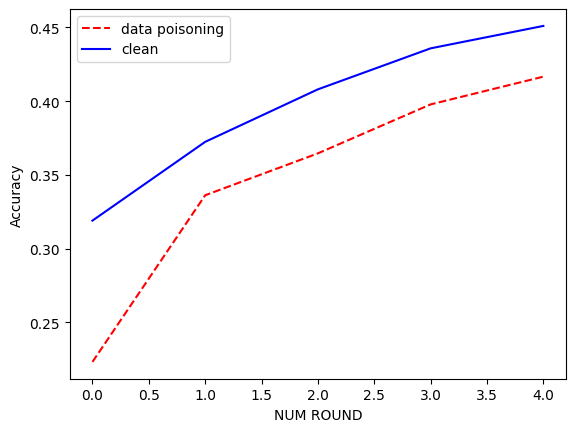

In [9]:
poisoned_accuracy = data_poison_results.metrics_distributed["accuracy"]
clean_accuracy = clean_results.metrics_distributed["accuracy"]
plt.plot([poisoned_accuracy[i][1] for i in range(NUM_ROUND)], label="data poisoning", color="red", ls = "--")
plt.plot([clean_accuracy[i][1] for i in range(NUM_ROUND)], label="clean", color="blue")
plt.xlabel("NUM ROUND")
plt.ylabel("Accuracy")
plt.legend()

#### Q1.2: Design your own model poisoning attack in which the malicious client poisons the model by manipulating **the parameters** of the model.

In this scenario, the malicious client can manipulate the model parameters to reduce the test accuracy of the global model. Please design and implement your own model poisoning attacks.



In [10]:

def train_poisoning_models(net, trainloader, epochs: int):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters())
    net.train()
    ## TODO: Model Poisoning attack ##

    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for images, labels in trainloader:
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)

            optimizer.zero_grad()

            outputs = net(images)
            loss = -criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            epoch_loss += loss
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
        epoch_loss /= len(trainloader.dataset)
        epoch_acc = correct / total
        print(f"Epoch {epoch+1}: train loss {epoch_loss}, accuracy {epoch_acc}")


    ##################################


class ModelPoisonClient(BaseFlowerClient):
    def fit(self, parameters, config):
        """Fit the model using the poisoned training method."""
        print(f"[Poisoning Client {self.cid}] fit, config: {config}")
        set_parameters(self.net, parameters)
        train_poisoning_models(self.net, self.trainloader, epochs=LOCAL_EPOCH)
        return get_parameters(self.net), len(self.trainloader), {}

def model_poison_client_fn(cid) -> FlowerClient:
    net = Net().to(DEVICE)
    trainloader = trainloaders[int(cid)]
    valloader = valloaders[int(cid)]
    if int(cid) in ADVERSARY_CID: # if the client is the adversary
        return ModelPoisonClient(cid, net, trainloader, valloader)
    return FlowerClient(cid, net, trainloader, valloader)

# Start simulation for model poisoning
model_poison_results = fl.simulation.start_simulation(
    client_fn=model_poison_client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=NUM_ROUND),  # Just three rounds
    strategy=strategy,
    client_resources=client_resources,
)

INFO flwr 2023-11-29 09:50:43,393 | app.py:178 | Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)
2023-11-29 09:50:49,493	INFO worker.py:1621 -- Started a local Ray instance.
INFO flwr 2023-11-29 09:50:51,144 | app.py:213 | Flower VCE: Ray initialized with resources: {'memory': 7864376526.0, 'object_store_memory': 3932188262.0, 'CPU': 2.0, 'node:172.28.0.12': 1.0, 'GPU': 1.0, 'node:__internal_head__': 1.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'memory': 7864376526.0, 'object_store_memory': 3932188262.0, 'CPU': 2.0, 'node:172.28.0.12': 1.0, 'GPU': 1.0, 'node:__internal_head__': 1.0}
INFO flwr 2023-11-29 09:50:51,152 | app.py:219 | Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
INFO:flwr:Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html


(DefaultActor pid=3777) [Client 1] get_parameters
(DefaultActor pid=3777) [Client 9] fit, config: {}
(DefaultActor pid=3777) Epoch 1: train loss 0.06556498259305954, accuracy 0.232
(DefaultActor pid=3777) [Client 4] fit, config: {}
(DefaultActor pid=3777) Epoch 1: train loss 0.06413865089416504, accuracy 0.2431111111111111
(DefaultActor pid=3777) [Client 8] fit, config: {}
(DefaultActor pid=3777) Epoch 1: train loss 0.06477877497673035, accuracy 0.23022222222222222
(DefaultActor pid=3777) [Client 2] fit, config: {}
(DefaultActor pid=3777) Epoch 1: train loss 0.06474923342466354, accuracy 0.23955555555555555
(DefaultActor pid=3777) [Poisoning Client 0] fit, config: {}
(DefaultActor pid=3777) Epoch 1: train loss -12320.7587890625, accuracy 0.09488888888888888
(DefaultActor pid=3777) [Client 7] fit, config: {}
(DefaultActor pid=3777) Epoch 1: train loss 0.064520925283432, accuracy 0.22044444444444444
(DefaultActor pid=3777) [Client 1] fit, config: {}
(DefaultActor pid=3777) Epoch 1: train

DEBUG flwr 2023-11-29 09:51:27,530 | server.py:236 | fit_round 1 received 10 results and 0 failures
DEBUG:flwr:fit_round 1 received 10 results and 0 failures
WARNING flwr 2023-11-29 09:51:27,562 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-11-29 09:51:27,565 | server.py:173 | evaluate_round 1: strategy sampled 10 clients (out of 10)
DEBUG:flwr:evaluate_round 1: strategy sampled 10 clients (out of 10)


(DefaultActor pid=3777) Epoch 1: train loss 0.06473410129547119, accuracy 0.2331111111111111
(DefaultActor pid=3777) [Client 2] evaluate, config: {}
(DefaultActor pid=3777) [Client 0] evaluate, config: {}
(DefaultActor pid=3777) [Client 7] evaluate, config: {}
(DefaultActor pid=3777) [Client 3] evaluate, config: {}
(DefaultActor pid=3777) [Client 5] evaluate, config: {}
(DefaultActor pid=3777) [Client 9] evaluate, config: {}
(DefaultActor pid=3777) [Client 4] evaluate, config: {}
(DefaultActor pid=3777) [Client 1] evaluate, config: {}
(DefaultActor pid=3777) [Client 6] evaluate, config: {}


DEBUG flwr 2023-11-29 09:51:45,751 | server.py:187 | evaluate_round 1 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 1 received 10 results and 0 failures
DEBUG flwr 2023-11-29 09:51:45,758 | server.py:222 | fit_round 2: strategy sampled 10 clients (out of 10)
DEBUG:flwr:fit_round 2: strategy sampled 10 clients (out of 10)


(DefaultActor pid=3777) [Client 8] evaluate, config: {}
(DefaultActor pid=3777) [Client 3] fit, config: {}
(DefaultActor pid=3777) Epoch 1: train loss 0.2524269223213196, accuracy 0.25022222222222223
(DefaultActor pid=3777) [Client 2] fit, config: {}
(DefaultActor pid=3777) Epoch 1: train loss 0.23163968324661255, accuracy 0.2624444444444444
(DefaultActor pid=3777) [Client 8] fit, config: {}
(DefaultActor pid=3777) Epoch 1: train loss 0.24692869186401367, accuracy 0.2653333333333333
(DefaultActor pid=3777) [Client 5] fit, config: {}
(DefaultActor pid=3777) Epoch 1: train loss 0.241879403591156, accuracy 0.24866666666666667
(DefaultActor pid=3777) [Client 9] fit, config: {}
(DefaultActor pid=3777) Epoch 1: train loss 0.2484252154827118, accuracy 0.2682222222222222
(DefaultActor pid=3777) [Poisoning Client 0] fit, config: {}
(DefaultActor pid=3777) Epoch 1: train loss -43601.265625, accuracy 0.09488888888888888
(DefaultActor pid=3777) [Client 1] fit, config: {}
(DefaultActor pid=3777) Ep

DEBUG flwr 2023-11-29 09:52:16,085 | server.py:236 | fit_round 2 received 10 results and 0 failures
DEBUG:flwr:fit_round 2 received 10 results and 0 failures
DEBUG flwr 2023-11-29 09:52:16,126 | server.py:173 | evaluate_round 2: strategy sampled 10 clients (out of 10)
DEBUG:flwr:evaluate_round 2: strategy sampled 10 clients (out of 10)


(DefaultActor pid=3777) Epoch 1: train loss 0.2448292374610901, accuracy 0.25955555555555554
(DefaultActor pid=3777) [Client 7] evaluate, config: {}
(DefaultActor pid=3777) [Client 5] evaluate, config: {}
(DefaultActor pid=3777) [Client 6] evaluate, config: {}
(DefaultActor pid=3777) [Client 2] evaluate, config: {}
(DefaultActor pid=3777) [Client 3] evaluate, config: {}
(DefaultActor pid=3777) [Client 1] evaluate, config: {}
(DefaultActor pid=3777) [Client 4] evaluate, config: {}
(DefaultActor pid=3777) [Client 9] evaluate, config: {}
(DefaultActor pid=3777) [Client 0] evaluate, config: {}


DEBUG flwr 2023-11-29 09:52:32,484 | server.py:187 | evaluate_round 2 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 2 received 10 results and 0 failures
DEBUG flwr 2023-11-29 09:52:32,487 | server.py:222 | fit_round 3: strategy sampled 10 clients (out of 10)
DEBUG:flwr:fit_round 3: strategy sampled 10 clients (out of 10)


(DefaultActor pid=3777) [Client 8] evaluate, config: {}
(DefaultActor pid=3777) [Client 3] fit, config: {}
(DefaultActor pid=3777) Epoch 1: train loss 0.6190342307090759, accuracy 0.25266666666666665
(DefaultActor pid=3777) [Client 6] fit, config: {}
(DefaultActor pid=3777) Epoch 1: train loss 0.6419874429702759, accuracy 0.24422222222222223
(DefaultActor pid=3777) [Client 2] fit, config: {}
(DefaultActor pid=3777) Epoch 1: train loss 0.6385070085525513, accuracy 0.25377777777777777
(DefaultActor pid=3777) [Client 9] fit, config: {}
(DefaultActor pid=3777) Epoch 1: train loss 0.6067245602607727, accuracy 0.2411111111111111
(DefaultActor pid=3777) [Client 5] fit, config: {}
(DefaultActor pid=3777) Epoch 1: train loss 0.6335497498512268, accuracy 0.24888888888888888
(DefaultActor pid=3777) [Client 4] fit, config: {}
(DefaultActor pid=3777) Epoch 1: train loss 0.644005298614502, accuracy 0.25177777777777777
(DefaultActor pid=3777) [Client 1] fit, config: {}
(DefaultActor pid=3777) Epoch 1

DEBUG flwr 2023-11-29 09:53:06,609 | server.py:236 | fit_round 3 received 10 results and 0 failures
DEBUG:flwr:fit_round 3 received 10 results and 0 failures
DEBUG flwr 2023-11-29 09:53:06,633 | server.py:173 | evaluate_round 3: strategy sampled 10 clients (out of 10)
DEBUG:flwr:evaluate_round 3: strategy sampled 10 clients (out of 10)


(DefaultActor pid=3777) Epoch 1: train loss 0.6370671987533569, accuracy 0.2548888888888889
(DefaultActor pid=3777) [Client 3] evaluate, config: {}
(DefaultActor pid=3777) [Client 9] evaluate, config: {}
(DefaultActor pid=3777) [Client 7] evaluate, config: {}
(DefaultActor pid=3777) [Client 1] evaluate, config: {}
(DefaultActor pid=3777) [Client 2] evaluate, config: {}
(DefaultActor pid=3777) [Client 4] evaluate, config: {}
(DefaultActor pid=3777) [Client 0] evaluate, config: {}
(DefaultActor pid=3777) [Client 8] evaluate, config: {}
(DefaultActor pid=3777) [Client 5] evaluate, config: {}


DEBUG flwr 2023-11-29 09:53:23,032 | server.py:187 | evaluate_round 3 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 3 received 10 results and 0 failures
DEBUG flwr 2023-11-29 09:53:23,038 | server.py:222 | fit_round 4: strategy sampled 10 clients (out of 10)
DEBUG:flwr:fit_round 4: strategy sampled 10 clients (out of 10)


(DefaultActor pid=3777) [Client 6] evaluate, config: {}
(DefaultActor pid=3777) [Client 8] fit, config: {}
(DefaultActor pid=3777) Epoch 1: train loss 1.770163893699646, accuracy 0.2548888888888889
(DefaultActor pid=3777) [Client 2] fit, config: {}
(DefaultActor pid=3777) Epoch 1: train loss 1.6726142168045044, accuracy 0.25155555555555553
(DefaultActor pid=3777) [Client 5] fit, config: {}
(DefaultActor pid=3777) Epoch 1: train loss 1.758737325668335, accuracy 0.23466666666666666
(DefaultActor pid=3777) [Client 7] fit, config: {}
(DefaultActor pid=3777) Epoch 1: train loss 1.624461054801941, accuracy 0.25555555555555554
(DefaultActor pid=3777) [Poisoning Client 0] fit, config: {}
(DefaultActor pid=3777) Epoch 1: train loss -75646.78125, accuracy 0.09488888888888888
(DefaultActor pid=3777) [Client 4] fit, config: {}
(DefaultActor pid=3777) Epoch 1: train loss 1.6565096378326416, accuracy 0.242
(DefaultActor pid=3777) [Client 3] fit, config: {}
(DefaultActor pid=3777) Epoch 1: train loss

DEBUG flwr 2023-11-29 09:53:55,559 | server.py:236 | fit_round 4 received 10 results and 0 failures
DEBUG:flwr:fit_round 4 received 10 results and 0 failures
DEBUG flwr 2023-11-29 09:53:55,587 | server.py:173 | evaluate_round 4: strategy sampled 10 clients (out of 10)
DEBUG:flwr:evaluate_round 4: strategy sampled 10 clients (out of 10)


(DefaultActor pid=3777) Epoch 1: train loss 1.692379117012024, accuracy 0.24488888888888888
(DefaultActor pid=3777) [Client 6] evaluate, config: {}
(DefaultActor pid=3777) [Client 9] evaluate, config: {}
(DefaultActor pid=3777) [Client 2] evaluate, config: {}
(DefaultActor pid=3777) [Client 8] evaluate, config: {}
(DefaultActor pid=3777) [Client 3] evaluate, config: {}
(DefaultActor pid=3777) [Client 0] evaluate, config: {}
(DefaultActor pid=3777) [Client 1] evaluate, config: {}
(DefaultActor pid=3777) [Client 5] evaluate, config: {}
(DefaultActor pid=3777) [Client 7] evaluate, config: {}


DEBUG flwr 2023-11-29 09:54:12,634 | server.py:187 | evaluate_round 4 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 4 received 10 results and 0 failures
DEBUG flwr 2023-11-29 09:54:12,637 | server.py:222 | fit_round 5: strategy sampled 10 clients (out of 10)
DEBUG:flwr:fit_round 5: strategy sampled 10 clients (out of 10)


(DefaultActor pid=3777) [Client 4] evaluate, config: {}
(DefaultActor pid=3777) [Client 9] fit, config: {}
(DefaultActor pid=3777) Epoch 1: train loss 2.911874294281006, accuracy 0.21933333333333332
(DefaultActor pid=3777) [Client 1] fit, config: {}
(DefaultActor pid=3777) Epoch 1: train loss 2.578070878982544, accuracy 0.24133333333333334
(DefaultActor pid=3777) [Poisoning Client 0] fit, config: {}
(DefaultActor pid=3777) Epoch 1: train loss -85522.8984375, accuracy 0.09488888888888888
(DefaultActor pid=3777) [Client 8] fit, config: {}
(DefaultActor pid=3777) Epoch 1: train loss 2.7955546379089355, accuracy 0.23755555555555555
(DefaultActor pid=3777) [Client 3] fit, config: {}
(DefaultActor pid=3777) Epoch 1: train loss 2.773912191390991, accuracy 0.22666666666666666
(DefaultActor pid=3777) [Client 4] fit, config: {}
(DefaultActor pid=3777) Epoch 1: train loss 2.8428878784179688, accuracy 0.226
(DefaultActor pid=3777) [Client 6] fit, config: {}
(DefaultActor pid=3777) Epoch 1: train l

DEBUG flwr 2023-11-29 09:54:43,086 | server.py:236 | fit_round 5 received 10 results and 0 failures
DEBUG:flwr:fit_round 5 received 10 results and 0 failures
DEBUG flwr 2023-11-29 09:54:43,116 | server.py:173 | evaluate_round 5: strategy sampled 10 clients (out of 10)
DEBUG:flwr:evaluate_round 5: strategy sampled 10 clients (out of 10)


(DefaultActor pid=3777) Epoch 1: train loss 2.7678558826446533, accuracy 0.234
(DefaultActor pid=3777) [Client 7] evaluate, config: {}
(DefaultActor pid=3777) [Client 1] evaluate, config: {}
(DefaultActor pid=3777) [Client 0] evaluate, config: {}
(DefaultActor pid=3777) [Client 2] evaluate, config: {}
(DefaultActor pid=3777) [Client 3] evaluate, config: {}
(DefaultActor pid=3777) [Client 5] evaluate, config: {}
(DefaultActor pid=3777) [Client 6] evaluate, config: {}
(DefaultActor pid=3777) [Client 9] evaluate, config: {}
(DefaultActor pid=3777) [Client 8] evaluate, config: {}


DEBUG flwr 2023-11-29 09:54:59,051 | server.py:187 | evaluate_round 5 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 5 received 10 results and 0 failures
INFO flwr 2023-11-29 09:54:59,056 | server.py:153 | FL finished in 241.41201805800006
INFO:flwr:FL finished in 241.41201805800006
INFO flwr 2023-11-29 09:54:59,061 | app.py:226 | app_fit: losses_distributed [(1, 5.370832643127441), (2, 16.154131964111333), (3, 39.17156528320312), (4, 64.44191491699218), (5, 102.61006362304688)]
INFO:flwr:app_fit: losses_distributed [(1, 5.370832643127441), (2, 16.154131964111333), (3, 39.17156528320312), (4, 64.44191491699218), (5, 102.61006362304688)]
INFO flwr 2023-11-29 09:54:59,062 | app.py:227 | app_fit: metrics_distributed_fit {}
INFO:flwr:app_fit: metrics_distributed_fit {}
INFO flwr 2023-11-29 09:54:59,065 | app.py:228 | app_fit: metrics_distributed {'accuracy': [(1, 0.09719999999999998), (2, 0.09719999999999998), (3, 0.09719999999999998), (4, 0.09719999999999998), (5, 0.09719999

(DefaultActor pid=3777) [Client 4] evaluate, config: {}


Compare the performance

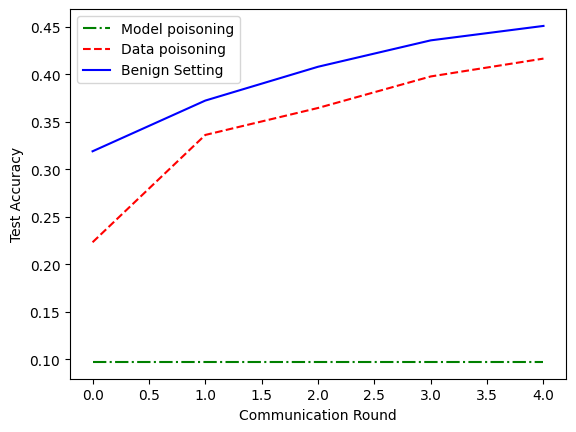

In [11]:
# Helping function
poisoned_accuracy = data_poison_results.metrics_distributed["accuracy"]
clean_accuracy = clean_results.metrics_distributed["accuracy"]
model_poison_accuracy = model_poison_results.metrics_distributed["accuracy"]

x= [i for i in range(NUM_ROUND)]
plt.plot(x,[model_poison_accuracy[i][1] for i in range(NUM_ROUND)], label="Model poisoning", color="green", ls = "-.")
plt.plot(x,[poisoned_accuracy[i][1] for i in range(NUM_ROUND)], label="Data poisoning", color="red", ls = "--")
plt.plot(x,[clean_accuracy[i][1] for i in range(NUM_ROUND)], label="Benign Setting", color="blue")
plt.xlabel("Communication Round")
plt.ylabel("Test Accuracy")
plt.legend()

#### Q1.3: Answer the following questions in your report:

1. Provide an explanation of the design of your data poisoning attack and model poisoning attack.
2. Is a model poisoning attack more effective than a data poisoning attack? If so, why?
3. When increasing the number of participating clients to 20 (i.e., changing `NUM_CLIENT` to 20), does the gap between the model poisoning attacks and data poisoning attack increase? Why or why not?

##### Report [TODO]:

1. Data Poisoning Attack:
  - I flip the labels of each data point such that
    - `flipped_label = 2` (if `true_label != 2`),
    - `flipped_label = 1` (if `true_label == 2`).
  - This forces the model to learn wrong class representations, thereby reducing test accuracy.

  Model Poisoning Attack:
  - I update the parameters of the network in the direction where the gradient of the loss wrt the parameters is maximized.
  - This forces the decision boundary away from the true decision boundary.

2. Model Poisoning Attack is more effective than the data poisoning attack.
This is due to the fact that coordinate-wise mean aggregate does not simply pick one of the updates to apply to the global model, but uses information from all the agents while computing the new update. Since the updates to the poisoned model are huge, the true mean of the global model gets shifted in each round. Thus, there is convergence to an effectively attacked global model.

3. By increasing `NUM_CLIENTS = 20`, the data poisoning attack will be less effective than at `NUM_CLIENTS = 10`. That is, test accuracy for data poisoning attacks will start to converge to the benign setting. Thus, the gap between the model poisoning attacks and data poisoning attacks will increase.
This is because with additional clients, more data would be present which will be representative of the true labels. Thus, the poisoning effect of the points with dirty labels will lessen. However, model poisoning attacks will still be effective as the parameter updates are large, thereby shifting the true mean significantly.

## Task 2: Replace the weighted average with element-wise median aggregation

### Median Defense

In [12]:
# Define the aggregation based on the element-wise median
class RobustFed(fl.server.strategy.fedavg.FedAvg):
    def aggregate_fit(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, FitRes]],
        failures: List[Union[Tuple[ClientProxy, FitRes], BaseException]],
    ) -> Tuple[Optional[Parameters], Dict[str, Scalar]]:
        """Aggregate fit results using weighted average."""

        weights_results = [
            (parameters_to_ndarrays(fit_res.parameters), fit_res.num_examples)
            for _, fit_res in results
        ]
        parameters_aggregated = ndarrays_to_parameters(
            aggregate_median(weights_results)
        )
        metrics_aggregated = {}
        return parameters_aggregated, metrics_aggregated

# Create an instance of the model and get the parameters
params = get_parameters(Net())

# Set upp the server for FL with median
median_strategy = RobustFed(
    fraction_fit=1.0,
    fraction_evaluate=1.0,
    min_fit_clients=NUM_CLIENTS,
    min_evaluate_clients=NUM_CLIENTS,
    min_available_clients=NUM_CLIENTS,
    initial_parameters=fl.common.ndarrays_to_parameters(params),
    evaluate_metrics_aggregation_fn=weighted_average,
)


In [13]:
# Start simulation
median_model_poison_results = fl.simulation.start_simulation(
    client_fn=model_poison_client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=NUM_ROUND),  # Just three rounds
    strategy=median_strategy,
    client_resources=client_resources,
)

# Start simulation
median_data_poison_results = fl.simulation.start_simulation(
    client_fn=data_poison_client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=NUM_ROUND),  # Just three rounds
    strategy=median_strategy,
    client_resources=client_resources,
)

median_clean_results = fl.simulation.start_simulation(
    client_fn=benign_client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=NUM_ROUND),  # Just three rounds
    strategy=median_strategy,
    client_resources=client_resources,
)



INFO flwr 2023-11-29 09:54:59,711 | app.py:178 | Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)
2023-11-29 09:55:06,329	INFO worker.py:1621 -- Started a local Ray instance.
INFO flwr 2023-11-29 09:55:08,432 | app.py:213 | Flower VCE: Ray initialized with resources: {'memory': 7864551015.0, 'node:__internal_head__': 1.0, 'object_store_memory': 3932275507.0, 'node:172.28.0.12': 1.0, 'GPU': 1.0, 'CPU': 2.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'memory': 7864551015.0, 'node:__internal_head__': 1.0, 'object_store_memory': 3932275507.0, 'node:172.28.0.12': 1.0, 'GPU': 1.0, 'CPU': 2.0}
INFO flwr 2023-11-29 09:55:08,436 | app.py:219 | Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
INFO:flwr:Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html


(DefaultActor pid=5114) [Client 7] fit, config: {}
(DefaultActor pid=5114) Epoch 1: train loss 0.06587409973144531, accuracy 0.21222222222222223
(DefaultActor pid=5114) [Client 6] fit, config: {}
(DefaultActor pid=5114) Epoch 1: train loss 0.06564818322658539, accuracy 0.21288888888888888
(DefaultActor pid=5114) [Client 3] fit, config: {}
(DefaultActor pid=5114) Epoch 1: train loss 0.06638018786907196, accuracy 0.2028888888888889
(DefaultActor pid=5114) [Client 1] fit, config: {}
(DefaultActor pid=5114) Epoch 1: train loss 0.06511961668729782, accuracy 0.23333333333333334
(DefaultActor pid=5114) [Client 4] fit, config: {}
(DefaultActor pid=5114) Epoch 1: train loss 0.0658276155591011, accuracy 0.22155555555555556
(DefaultActor pid=5114) [Client 8] fit, config: {}
(DefaultActor pid=5114) Epoch 1: train loss 0.06476061046123505, accuracy 0.23422222222222222
(DefaultActor pid=5114) [Client 9] fit, config: {}
(DefaultActor pid=5114) Epoch 1: train loss 0.06576240062713623, accuracy 0.20622

DEBUG flwr 2023-11-29 09:55:45,867 | server.py:236 | fit_round 1 received 10 results and 0 failures
DEBUG:flwr:fit_round 1 received 10 results and 0 failures
DEBUG flwr 2023-11-29 09:55:45,934 | server.py:173 | evaluate_round 1: strategy sampled 10 clients (out of 10)
DEBUG:flwr:evaluate_round 1: strategy sampled 10 clients (out of 10)


(DefaultActor pid=5114) Epoch 1: train loss 0.0654088482260704, accuracy 0.21955555555555556
(DefaultActor pid=5114) [Client 9] evaluate, config: {}
(DefaultActor pid=5114) [Client 7] evaluate, config: {}
(DefaultActor pid=5114) [Client 0] evaluate, config: {}
(DefaultActor pid=5114) [Client 5] evaluate, config: {}
(DefaultActor pid=5114) [Client 2] evaluate, config: {}
(DefaultActor pid=5114) [Client 6] evaluate, config: {}
(DefaultActor pid=5114) [Client 4] evaluate, config: {}
(DefaultActor pid=5114) [Client 8] evaluate, config: {}
(DefaultActor pid=5114) [Client 1] evaluate, config: {}


DEBUG flwr 2023-11-29 09:56:03,003 | server.py:187 | evaluate_round 1 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 1 received 10 results and 0 failures
DEBUG flwr 2023-11-29 09:56:03,006 | server.py:222 | fit_round 2: strategy sampled 10 clients (out of 10)
DEBUG:flwr:fit_round 2: strategy sampled 10 clients (out of 10)


(DefaultActor pid=5114) [Client 3] evaluate, config: {}
(DefaultActor pid=5114) [Client 5] fit, config: {}
(DefaultActor pid=5114) Epoch 1: train loss 0.05879795551300049, accuracy 0.296
(DefaultActor pid=5114) [Poisoning Client 0] fit, config: {}
(DefaultActor pid=5114) Epoch 1: train loss -14333.46484375, accuracy 0.10333333333333333
(DefaultActor pid=5114) [Client 7] fit, config: {}
(DefaultActor pid=5114) Epoch 1: train loss 0.058412760496139526, accuracy 0.3022222222222222
(DefaultActor pid=5114) [Client 6] fit, config: {}
(DefaultActor pid=5114) Epoch 1: train loss 0.05961943417787552, accuracy 0.2942222222222222
(DefaultActor pid=5114) [Client 3] fit, config: {}
(DefaultActor pid=5114) Epoch 1: train loss 0.05867686867713928, accuracy 0.31066666666666665
(DefaultActor pid=5114) [Client 2] fit, config: {}
(DefaultActor pid=5114) Epoch 1: train loss 0.058943264186382294, accuracy 0.30266666666666664
(DefaultActor pid=5114) [Client 8] fit, config: {}
(DefaultActor pid=5114) Epoch 1

DEBUG flwr 2023-11-29 09:56:37,180 | server.py:236 | fit_round 2 received 10 results and 0 failures
DEBUG:flwr:fit_round 2 received 10 results and 0 failures
DEBUG flwr 2023-11-29 09:56:37,216 | server.py:173 | evaluate_round 2: strategy sampled 10 clients (out of 10)
DEBUG:flwr:evaluate_round 2: strategy sampled 10 clients (out of 10)


(DefaultActor pid=5114) Epoch 1: train loss 0.058775365352630615, accuracy 0.314
(DefaultActor pid=5114) [Client 8] evaluate, config: {}
(DefaultActor pid=5114) [Client 2] evaluate, config: {}
(DefaultActor pid=5114) [Client 0] evaluate, config: {}
(DefaultActor pid=5114) [Client 5] evaluate, config: {}
(DefaultActor pid=5114) [Client 1] evaluate, config: {}
(DefaultActor pid=5114) [Client 7] evaluate, config: {}
(DefaultActor pid=5114) [Client 9] evaluate, config: {}
(DefaultActor pid=5114) [Client 4] evaluate, config: {}
(DefaultActor pid=5114) [Client 6] evaluate, config: {}


DEBUG flwr 2023-11-29 09:56:55,419 | server.py:187 | evaluate_round 2 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 2 received 10 results and 0 failures
DEBUG flwr 2023-11-29 09:56:55,425 | server.py:222 | fit_round 3: strategy sampled 10 clients (out of 10)
DEBUG:flwr:fit_round 3: strategy sampled 10 clients (out of 10)


(DefaultActor pid=5114) [Client 3] evaluate, config: {}
(DefaultActor pid=5114) [Client 3] fit, config: {}
(DefaultActor pid=5114) Epoch 1: train loss 0.05490664020180702, accuracy 0.36
(DefaultActor pid=5114) [Client 7] fit, config: {}
(DefaultActor pid=5114) Epoch 1: train loss 0.053369566798210144, accuracy 0.37533333333333335
(DefaultActor pid=5114) [Client 5] fit, config: {}
(DefaultActor pid=5114) Epoch 1: train loss 0.054923560470342636, accuracy 0.35488888888888886
(DefaultActor pid=5114) [Client 9] fit, config: {}
(DefaultActor pid=5114) Epoch 1: train loss 0.05448406934738159, accuracy 0.356
(DefaultActor pid=5114) [Client 2] fit, config: {}
(DefaultActor pid=5114) Epoch 1: train loss 0.05490141361951828, accuracy 0.35444444444444445
(DefaultActor pid=5114) [Client 4] fit, config: {}
(DefaultActor pid=5114) Epoch 1: train loss 0.054673366248607635, accuracy 0.35933333333333334
(DefaultActor pid=5114) [Client 8] fit, config: {}
(DefaultActor pid=5114) Epoch 1: train loss 0.054

DEBUG flwr 2023-11-29 09:57:35,016 | server.py:236 | fit_round 3 received 10 results and 0 failures
DEBUG:flwr:fit_round 3 received 10 results and 0 failures
DEBUG flwr 2023-11-29 09:57:35,077 | server.py:173 | evaluate_round 3: strategy sampled 10 clients (out of 10)
DEBUG:flwr:evaluate_round 3: strategy sampled 10 clients (out of 10)


(DefaultActor pid=5114) Epoch 1: train loss -14628.7470703125, accuracy 0.10622222222222222
(DefaultActor pid=5114) [Client 9] evaluate, config: {}
(DefaultActor pid=5114) [Client 1] evaluate, config: {}
(DefaultActor pid=5114) [Client 8] evaluate, config: {}
(DefaultActor pid=5114) [Client 6] evaluate, config: {}
(DefaultActor pid=5114) [Client 4] evaluate, config: {}
(DefaultActor pid=5114) [Client 5] evaluate, config: {}
(DefaultActor pid=5114) [Client 0] evaluate, config: {}
(DefaultActor pid=5114) [Client 7] evaluate, config: {}
(DefaultActor pid=5114) [Client 3] evaluate, config: {}


DEBUG flwr 2023-11-29 09:57:54,345 | server.py:187 | evaluate_round 3 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 3 received 10 results and 0 failures
DEBUG flwr 2023-11-29 09:57:54,351 | server.py:222 | fit_round 4: strategy sampled 10 clients (out of 10)
DEBUG:flwr:fit_round 4: strategy sampled 10 clients (out of 10)


(DefaultActor pid=5114) [Client 2] evaluate, config: {}
(DefaultActor pid=5114) [Client 1] fit, config: {}
(DefaultActor pid=5114) Epoch 1: train loss 0.0519552119076252, accuracy 0.3928888888888889
(DefaultActor pid=5114) [Client 2] fit, config: {}
(DefaultActor pid=5114) Epoch 1: train loss 0.05239573121070862, accuracy 0.38866666666666666
(DefaultActor pid=5114) [Client 3] fit, config: {}
(DefaultActor pid=5114) Epoch 1: train loss 0.05237272381782532, accuracy 0.3857777777777778
(DefaultActor pid=5114) [Client 6] fit, config: {}
(DefaultActor pid=5114) Epoch 1: train loss 0.05331544205546379, accuracy 0.3831111111111111
(DefaultActor pid=5114) [Client 7] fit, config: {}
(DefaultActor pid=5114) Epoch 1: train loss 0.051181305199861526, accuracy 0.4048888888888889
(DefaultActor pid=5114) [Client 5] fit, config: {}
(DefaultActor pid=5114) Epoch 1: train loss 0.05293329432606697, accuracy 0.37622222222222224
(DefaultActor pid=5114) [Client 9] fit, config: {}
(DefaultActor pid=5114) Epo

DEBUG flwr 2023-11-29 09:58:32,135 | server.py:236 | fit_round 4 received 10 results and 0 failures
DEBUG:flwr:fit_round 4 received 10 results and 0 failures
DEBUG flwr 2023-11-29 09:58:32,214 | server.py:173 | evaluate_round 4: strategy sampled 10 clients (out of 10)
DEBUG:flwr:evaluate_round 4: strategy sampled 10 clients (out of 10)


(DefaultActor pid=5114) Epoch 1: train loss 0.051876600831747055, accuracy 0.39755555555555555
(DefaultActor pid=5114) [Client 3] evaluate, config: {}
(DefaultActor pid=5114) [Client 4] evaluate, config: {}
(DefaultActor pid=5114) [Client 1] evaluate, config: {}
(DefaultActor pid=5114) [Client 5] evaluate, config: {}
(DefaultActor pid=5114) [Client 8] evaluate, config: {}
(DefaultActor pid=5114) [Client 0] evaluate, config: {}
(DefaultActor pid=5114) [Client 7] evaluate, config: {}
(DefaultActor pid=5114) [Client 2] evaluate, config: {}
(DefaultActor pid=5114) [Client 9] evaluate, config: {}


DEBUG flwr 2023-11-29 09:58:52,809 | server.py:187 | evaluate_round 4 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 4 received 10 results and 0 failures
DEBUG flwr 2023-11-29 09:58:52,816 | server.py:222 | fit_round 5: strategy sampled 10 clients (out of 10)
DEBUG:flwr:fit_round 5: strategy sampled 10 clients (out of 10)


(DefaultActor pid=5114) [Client 6] evaluate, config: {}
(DefaultActor pid=5114) [Client 8] fit, config: {}
(DefaultActor pid=5114) Epoch 1: train loss 0.05002143606543541, accuracy 0.42244444444444446
(DefaultActor pid=5114) [Client 3] fit, config: {}
(DefaultActor pid=5114) Epoch 1: train loss 0.05081048235297203, accuracy 0.40644444444444444
(DefaultActor pid=5114) [Poisoning Client 0] fit, config: {}
(DefaultActor pid=5114) Epoch 1: train loss -17024.060546875, accuracy 0.10711111111111112
(DefaultActor pid=5114) [Client 9] fit, config: {}
(DefaultActor pid=5114) Epoch 1: train loss 0.0509854331612587, accuracy 0.39911111111111114
(DefaultActor pid=5114) [Client 6] fit, config: {}
(DefaultActor pid=5114) Epoch 1: train loss 0.05207370966672897, accuracy 0.3913333333333333
(DefaultActor pid=5114) [Client 1] fit, config: {}
(DefaultActor pid=5114) Epoch 1: train loss 0.05009908601641655, accuracy 0.4066666666666667
(DefaultActor pid=5114) [Client 4] fit, config: {}
(DefaultActor pid=5

DEBUG flwr 2023-11-29 09:59:26,817 | server.py:236 | fit_round 5 received 10 results and 0 failures
DEBUG:flwr:fit_round 5 received 10 results and 0 failures
DEBUG flwr 2023-11-29 09:59:26,857 | server.py:173 | evaluate_round 5: strategy sampled 10 clients (out of 10)
DEBUG:flwr:evaluate_round 5: strategy sampled 10 clients (out of 10)


(DefaultActor pid=5114) Epoch 1: train loss 0.05068875476717949, accuracy 0.40155555555555555
(DefaultActor pid=5114) [Client 5] evaluate, config: {}
(DefaultActor pid=5114) [Client 3] evaluate, config: {}
(DefaultActor pid=5114) [Client 9] evaluate, config: {}
(DefaultActor pid=5114) [Client 6] evaluate, config: {}
(DefaultActor pid=5114) [Client 2] evaluate, config: {}
(DefaultActor pid=5114) [Client 0] evaluate, config: {}
(DefaultActor pid=5114) [Client 4] evaluate, config: {}
(DefaultActor pid=5114) [Client 7] evaluate, config: {}
(DefaultActor pid=5114) [Client 1] evaluate, config: {}


DEBUG flwr 2023-11-29 09:59:42,720 | server.py:187 | evaluate_round 5 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 5 received 10 results and 0 failures
INFO flwr 2023-11-29 09:59:42,724 | server.py:153 | FL finished in 274.2281585049999
INFO:flwr:FL finished in 274.2281585049999
INFO flwr 2023-11-29 09:59:42,730 | app.py:226 | app_fit: losses_distributed [(1, 0.06394583194255829), (2, 0.056965114855766295), (3, 0.053367587494850155), (4, 0.05165802695751191), (5, 0.050068980097770686)]
INFO:flwr:app_fit: losses_distributed [(1, 0.06394583194255829), (2, 0.056965114855766295), (3, 0.053367587494850155), (4, 0.05165802695751191), (5, 0.050068980097770686)]
INFO flwr 2023-11-29 09:59:42,736 | app.py:227 | app_fit: metrics_distributed_fit {}
INFO:flwr:app_fit: metrics_distributed_fit {}
INFO flwr 2023-11-29 09:59:42,739 | app.py:228 | app_fit: metrics_distributed {'accuracy': [(1, 0.2864), (2, 0.3402), (3, 0.3778), (4, 0.3974), (5, 0.4154)], 'accuracy_per_client': [(1, [0.2

(DefaultActor pid=5114) [Client 8] evaluate, config: {}


2023-11-29 09:59:46,924	INFO worker.py:1621 -- Started a local Ray instance.
INFO flwr 2023-11-29 09:59:49,033 | app.py:213 | Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'node:172.28.0.12': 1.0, 'GPU': 1.0, 'memory': 7865423463.0, 'object_store_memory': 3932711731.0, 'CPU': 2.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'node:172.28.0.12': 1.0, 'GPU': 1.0, 'memory': 7865423463.0, 'object_store_memory': 3932711731.0, 'CPU': 2.0}
INFO flwr 2023-11-29 09:59:49,041 | app.py:219 | Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
INFO:flwr:Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
INFO flwr 2023-11-29 09:59:49,046 | app.py:242 | Flower VCE: Resources for each Virtual Client: {'num_gpus': 1, 'num_cpus': 1}
INFO:flwr:Flower VCE: Resources for each Virtual Client: {'num_gpus': 1, 'num_cpus': 1}
INFO flwr 

(DefaultActor pid=6574) [Client 7] get_parameters
(DefaultActor pid=6574) [Client 2] fit, config: {}
(DefaultActor pid=6574) Epoch 1: train loss 0.06534518301486969, accuracy 0.21088888888888888
(DefaultActor pid=6574) [Client 8] fit, config: {}
(DefaultActor pid=6574) Epoch 1: train loss 0.06515023112297058, accuracy 0.21088888888888888
(DefaultActor pid=6574) [Client 9] fit, config: {}
(DefaultActor pid=6574) Epoch 1: train loss 0.06590781360864639, accuracy 0.21444444444444444
(DefaultActor pid=6574) [Client 5] fit, config: {}
(DefaultActor pid=6574) Epoch 1: train loss 0.06662340462207794, accuracy 0.19111111111111112
(DefaultActor pid=6574) [Client 1] fit, config: {}
(DefaultActor pid=6574) Epoch 1: train loss 0.06560097634792328, accuracy 0.2137777777777778
(DefaultActor pid=6574) [Poisoning Client 0] fit, config: {}
(DefaultActor pid=6574) Epoch 1: train loss 0.014913897961378098, accuracy 0.09355555555555556
(DefaultActor pid=6574) [Client 6] fit, config: {}
(DefaultActor pid=6

DEBUG flwr 2023-11-29 10:00:28,075 | server.py:236 | fit_round 1 received 10 results and 0 failures
DEBUG:flwr:fit_round 1 received 10 results and 0 failures
DEBUG flwr 2023-11-29 10:00:28,118 | server.py:173 | evaluate_round 1: strategy sampled 10 clients (out of 10)
DEBUG:flwr:evaluate_round 1: strategy sampled 10 clients (out of 10)


(DefaultActor pid=6574) Epoch 1: train loss 0.06551063060760498, accuracy 0.2157777777777778
(DefaultActor pid=6574) [Client 6] evaluate, config: {}
(DefaultActor pid=6574) [Client 2] evaluate, config: {}
(DefaultActor pid=6574) [Client 7] evaluate, config: {}
(DefaultActor pid=6574) [Client 4] evaluate, config: {}
(DefaultActor pid=6574) [Client 9] evaluate, config: {}
(DefaultActor pid=6574) [Client 1] evaluate, config: {}
(DefaultActor pid=6574) [Client 5] evaluate, config: {}
(DefaultActor pid=6574) [Client 0] evaluate, config: {}
(DefaultActor pid=6574) [Client 8] evaluate, config: {}


DEBUG flwr 2023-11-29 10:00:44,062 | server.py:187 | evaluate_round 1 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 1 received 10 results and 0 failures
DEBUG flwr 2023-11-29 10:00:44,068 | server.py:222 | fit_round 2: strategy sampled 10 clients (out of 10)
DEBUG:flwr:fit_round 2: strategy sampled 10 clients (out of 10)


(DefaultActor pid=6574) [Client 3] evaluate, config: {}
(DefaultActor pid=6574) [Client 2] fit, config: {}
(DefaultActor pid=6574) Epoch 1: train loss 0.059209033846855164, accuracy 0.3011111111111111
(DefaultActor pid=6574) [Client 4] fit, config: {}
(DefaultActor pid=6574) Epoch 1: train loss 0.05915914103388786, accuracy 0.294
(DefaultActor pid=6574) [Client 3] fit, config: {}
(DefaultActor pid=6574) Epoch 1: train loss 0.05922999605536461, accuracy 0.30533333333333335
(DefaultActor pid=6574) [Client 8] fit, config: {}
(DefaultActor pid=6574) Epoch 1: train loss 0.058748312294483185, accuracy 0.29688888888888887
(DefaultActor pid=6574) [Client 5] fit, config: {}
(DefaultActor pid=6574) Epoch 1: train loss 0.059737373143434525, accuracy 0.30822222222222223
(DefaultActor pid=6574) [Client 7] fit, config: {}
(DefaultActor pid=6574) Epoch 1: train loss 0.058974526822566986, accuracy 0.3006666666666667
(DefaultActor pid=6574) [Client 1] fit, config: {}
(DefaultActor pid=6574) Epoch 1: tr

DEBUG flwr 2023-11-29 10:01:13,315 | server.py:236 | fit_round 2 received 10 results and 0 failures
DEBUG:flwr:fit_round 2 received 10 results and 0 failures
DEBUG flwr 2023-11-29 10:01:13,354 | server.py:173 | evaluate_round 2: strategy sampled 10 clients (out of 10)
DEBUG:flwr:evaluate_round 2: strategy sampled 10 clients (out of 10)


(DefaultActor pid=6574) Epoch 1: train loss 0.012446709908545017, accuracy 0.09777777777777778
(DefaultActor pid=6574) [Client 5] evaluate, config: {}
(DefaultActor pid=6574) [Client 4] evaluate, config: {}
(DefaultActor pid=6574) [Client 6] evaluate, config: {}
(DefaultActor pid=6574) [Client 8] evaluate, config: {}
(DefaultActor pid=6574) [Client 0] evaluate, config: {}
(DefaultActor pid=6574) [Client 1] evaluate, config: {}
(DefaultActor pid=6574) [Client 3] evaluate, config: {}
(DefaultActor pid=6574) [Client 9] evaluate, config: {}
(DefaultActor pid=6574) [Client 2] evaluate, config: {}


DEBUG flwr 2023-11-29 10:01:29,156 | server.py:187 | evaluate_round 2 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 2 received 10 results and 0 failures
DEBUG flwr 2023-11-29 10:01:29,161 | server.py:222 | fit_round 3: strategy sampled 10 clients (out of 10)
DEBUG:flwr:fit_round 3: strategy sampled 10 clients (out of 10)


(DefaultActor pid=6574) [Client 7] evaluate, config: {}
(DefaultActor pid=6574) [Client 6] fit, config: {}
(DefaultActor pid=6574) Epoch 1: train loss 0.05534728989005089, accuracy 0.35533333333333333
(DefaultActor pid=6574) [Client 7] fit, config: {}
(DefaultActor pid=6574) Epoch 1: train loss 0.05359073355793953, accuracy 0.37355555555555553
(DefaultActor pid=6574) [Client 8] fit, config: {}
(DefaultActor pid=6574) Epoch 1: train loss 0.05384447053074837, accuracy 0.37533333333333335
(DefaultActor pid=6574) [Client 2] fit, config: {}
(DefaultActor pid=6574) Epoch 1: train loss 0.054751742631196976, accuracy 0.3611111111111111
(DefaultActor pid=6574) [Client 1] fit, config: {}
(DefaultActor pid=6574) Epoch 1: train loss 0.0538141094148159, accuracy 0.37022222222222223
(DefaultActor pid=6574) [Client 3] fit, config: {}
(DefaultActor pid=6574) Epoch 1: train loss 0.05458815395832062, accuracy 0.3531111111111111
(DefaultActor pid=6574) [Poisoning Client 0] fit, config: {}
(DefaultActor p

DEBUG flwr 2023-11-29 10:02:00,514 | server.py:236 | fit_round 3 received 10 results and 0 failures
DEBUG:flwr:fit_round 3 received 10 results and 0 failures
DEBUG flwr 2023-11-29 10:02:00,562 | server.py:173 | evaluate_round 3: strategy sampled 10 clients (out of 10)
DEBUG:flwr:evaluate_round 3: strategy sampled 10 clients (out of 10)


(DefaultActor pid=6574) Epoch 1: train loss 0.05444936081767082, accuracy 0.3642222222222222
(DefaultActor pid=6574) [Client 0] evaluate, config: {}
(DefaultActor pid=6574) [Client 9] evaluate, config: {}
(DefaultActor pid=6574) [Client 6] evaluate, config: {}
(DefaultActor pid=6574) [Client 3] evaluate, config: {}
(DefaultActor pid=6574) [Client 2] evaluate, config: {}
(DefaultActor pid=6574) [Client 8] evaluate, config: {}
(DefaultActor pid=6574) [Client 1] evaluate, config: {}
(DefaultActor pid=6574) [Client 4] evaluate, config: {}
(DefaultActor pid=6574) [Client 5] evaluate, config: {}


DEBUG flwr 2023-11-29 10:02:16,479 | server.py:187 | evaluate_round 3 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 3 received 10 results and 0 failures
DEBUG flwr 2023-11-29 10:02:16,485 | server.py:222 | fit_round 4: strategy sampled 10 clients (out of 10)
DEBUG:flwr:fit_round 4: strategy sampled 10 clients (out of 10)


(DefaultActor pid=6574) [Client 7] evaluate, config: {}
(DefaultActor pid=6574) [Client 9] fit, config: {}
(DefaultActor pid=6574) Epoch 1: train loss 0.052818022668361664, accuracy 0.388
(DefaultActor pid=6574) [Client 8] fit, config: {}
(DefaultActor pid=6574) Epoch 1: train loss 0.05194782838225365, accuracy 0.392
(DefaultActor pid=6574) [Client 6] fit, config: {}
(DefaultActor pid=6574) Epoch 1: train loss 0.053040292114019394, accuracy 0.3675555555555556
(DefaultActor pid=6574) [Client 1] fit, config: {}
(DefaultActor pid=6574) Epoch 1: train loss 0.05109654366970062, accuracy 0.4093333333333333
(DefaultActor pid=6574) [Client 3] fit, config: {}
(DefaultActor pid=6574) Epoch 1: train loss 0.052225809544324875, accuracy 0.39222222222222225
(DefaultActor pid=6574) [Client 4] fit, config: {}
(DefaultActor pid=6574) Epoch 1: train loss 0.05205034837126732, accuracy 0.38755555555555554
(DefaultActor pid=6574) [Client 2] fit, config: {}
(DefaultActor pid=6574) Epoch 1: train loss 0.0524

DEBUG flwr 2023-11-29 10:02:46,064 | server.py:236 | fit_round 4 received 10 results and 0 failures
DEBUG:flwr:fit_round 4 received 10 results and 0 failures
DEBUG flwr 2023-11-29 10:02:46,100 | server.py:173 | evaluate_round 4: strategy sampled 10 clients (out of 10)
DEBUG:flwr:evaluate_round 4: strategy sampled 10 clients (out of 10)


(DefaultActor pid=6574) Epoch 1: train loss 0.013164366595447063, accuracy 0.10088888888888889
(DefaultActor pid=6574) [Client 0] evaluate, config: {}
(DefaultActor pid=6574) [Client 7] evaluate, config: {}
(DefaultActor pid=6574) [Client 9] evaluate, config: {}
(DefaultActor pid=6574) [Client 3] evaluate, config: {}
(DefaultActor pid=6574) [Client 2] evaluate, config: {}
(DefaultActor pid=6574) [Client 6] evaluate, config: {}
(DefaultActor pid=6574) [Client 1] evaluate, config: {}
(DefaultActor pid=6574) [Client 5] evaluate, config: {}
(DefaultActor pid=6574) [Client 4] evaluate, config: {}


DEBUG flwr 2023-11-29 10:03:02,230 | server.py:187 | evaluate_round 4 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 4 received 10 results and 0 failures
DEBUG flwr 2023-11-29 10:03:02,235 | server.py:222 | fit_round 5: strategy sampled 10 clients (out of 10)
DEBUG:flwr:fit_round 5: strategy sampled 10 clients (out of 10)


(DefaultActor pid=6574) [Client 8] evaluate, config: {}
(DefaultActor pid=6574) [Client 4] fit, config: {}
(DefaultActor pid=6574) Epoch 1: train loss 0.0500287190079689, accuracy 0.42
(DefaultActor pid=6574) [Poisoning Client 0] fit, config: {}
(DefaultActor pid=6574) Epoch 1: train loss 0.012689625844359398, accuracy 0.10022222222222223
(DefaultActor pid=6574) [Client 2] fit, config: {}
(DefaultActor pid=6574) Epoch 1: train loss 0.051068320870399475, accuracy 0.4073333333333333
(DefaultActor pid=6574) [Client 5] fit, config: {}
(DefaultActor pid=6574) Epoch 1: train loss 0.050616465508937836, accuracy 0.40955555555555556
(DefaultActor pid=6574) [Client 9] fit, config: {}
(DefaultActor pid=6574) Epoch 1: train loss 0.05116825923323631, accuracy 0.40844444444444444
(DefaultActor pid=6574) [Client 7] fit, config: {}
(DefaultActor pid=6574) Epoch 1: train loss 0.04944184422492981, accuracy 0.43066666666666664
(DefaultActor pid=6574) [Client 1] fit, config: {}
(DefaultActor pid=6574) Epo

DEBUG flwr 2023-11-29 10:03:31,502 | server.py:236 | fit_round 5 received 10 results and 0 failures
DEBUG:flwr:fit_round 5 received 10 results and 0 failures
DEBUG flwr 2023-11-29 10:03:31,537 | server.py:173 | evaluate_round 5: strategy sampled 10 clients (out of 10)
DEBUG:flwr:evaluate_round 5: strategy sampled 10 clients (out of 10)


(DefaultActor pid=6574) Epoch 1: train loss 0.050997134298086166, accuracy 0.40044444444444444
(DefaultActor pid=6574) [Client 1] evaluate, config: {}
(DefaultActor pid=6574) [Client 4] evaluate, config: {}
(DefaultActor pid=6574) [Client 8] evaluate, config: {}
(DefaultActor pid=6574) [Client 0] evaluate, config: {}
(DefaultActor pid=6574) [Client 6] evaluate, config: {}
(DefaultActor pid=6574) [Client 2] evaluate, config: {}
(DefaultActor pid=6574) [Client 3] evaluate, config: {}
(DefaultActor pid=6574) [Client 9] evaluate, config: {}
(DefaultActor pid=6574) [Client 5] evaluate, config: {}


DEBUG flwr 2023-11-29 10:03:47,401 | server.py:187 | evaluate_round 5 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 5 received 10 results and 0 failures
INFO flwr 2023-11-29 10:03:47,406 | server.py:153 | FL finished in 229.90676156699988
INFO:flwr:FL finished in 229.90676156699988
INFO flwr 2023-11-29 10:03:47,408 | app.py:226 | app_fit: losses_distributed [(1, 0.06522287356853484), (2, 0.05609790086746217), (3, 0.05263391497135163), (4, 0.05118419780731202), (5, 0.049914684104919435)]
INFO:flwr:app_fit: losses_distributed [(1, 0.06522287356853484), (2, 0.05609790086746217), (3, 0.05263391497135163), (4, 0.05118419780731202), (5, 0.049914684104919435)]
INFO flwr 2023-11-29 10:03:47,411 | app.py:227 | app_fit: metrics_distributed_fit {}
INFO:flwr:app_fit: metrics_distributed_fit {}
INFO flwr 2023-11-29 10:03:47,414 | app.py:228 | app_fit: metrics_distributed {'accuracy': [(1, 0.2484), (2, 0.36019999999999996), (3, 0.39180000000000004), (4, 0.4034000000000001), (5, 0.4220

(DefaultActor pid=6574) [Client 7] evaluate, config: {}


2023-11-29 10:03:51,621	INFO worker.py:1621 -- Started a local Ray instance.
INFO flwr 2023-11-29 10:03:55,257 | app.py:213 | Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'node:__internal_head__': 1.0, 'object_store_memory': 3932701900.0, 'memory': 7865403803.0, 'node:172.28.0.12': 1.0, 'GPU': 1.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'node:__internal_head__': 1.0, 'object_store_memory': 3932701900.0, 'memory': 7865403803.0, 'node:172.28.0.12': 1.0, 'GPU': 1.0}
INFO flwr 2023-11-29 10:03:55,266 | app.py:219 | Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
INFO:flwr:Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
INFO flwr 2023-11-29 10:03:55,271 | app.py:242 | Flower VCE: Resources for each Virtual Client: {'num_gpus': 1, 'num_cpus': 1}
INFO:flwr:Flower VCE: Resources for each Virtual Client: {'num_gpus': 1, 'num_cpus': 1}
INFO flwr 

(DefaultActor pid=7881) [Client 6] get_parameters
(DefaultActor pid=7881) [Client 6] fit, config: {}
(DefaultActor pid=7881) Epoch 1: train loss 0.06600390374660492, accuracy 0.2157777777777778
(DefaultActor pid=7881) [Client 0] fit, config: {}
(DefaultActor pid=7881) Epoch 1: train loss 0.06637539714574814, accuracy 0.20422222222222222
(DefaultActor pid=7881) [Client 7] fit, config: {}
(DefaultActor pid=7881) Epoch 1: train loss 0.06633435189723969, accuracy 0.22844444444444445
(DefaultActor pid=7881) [Client 4] fit, config: {}
(DefaultActor pid=7881) Epoch 1: train loss 0.06589372456073761, accuracy 0.22444444444444445
(DefaultActor pid=7881) [Client 8] fit, config: {}
(DefaultActor pid=7881) Epoch 1: train loss 0.06613816320896149, accuracy 0.21622222222222223
(DefaultActor pid=7881) [Client 1] fit, config: {}
(DefaultActor pid=7881) Epoch 1: train loss 0.06663618236780167, accuracy 0.21133333333333335
(DefaultActor pid=7881) [Client 2] fit, config: {}
(DefaultActor pid=7881) Epoch 

DEBUG flwr 2023-11-29 10:04:31,627 | server.py:236 | fit_round 1 received 10 results and 0 failures
DEBUG:flwr:fit_round 1 received 10 results and 0 failures
DEBUG flwr 2023-11-29 10:04:31,673 | server.py:173 | evaluate_round 1: strategy sampled 10 clients (out of 10)
DEBUG:flwr:evaluate_round 1: strategy sampled 10 clients (out of 10)


(DefaultActor pid=7881) Epoch 1: train loss 0.06696265935897827, accuracy 0.20022222222222222
(DefaultActor pid=7881) [Client 9] evaluate, config: {}
(DefaultActor pid=7881) [Client 2] evaluate, config: {}
(DefaultActor pid=7881) [Client 7] evaluate, config: {}
(DefaultActor pid=7881) [Client 1] evaluate, config: {}
(DefaultActor pid=7881) [Client 3] evaluate, config: {}
(DefaultActor pid=7881) [Client 6] evaluate, config: {}
(DefaultActor pid=7881) [Client 4] evaluate, config: {}
(DefaultActor pid=7881) [Client 8] evaluate, config: {}
(DefaultActor pid=7881) [Client 5] evaluate, config: {}


DEBUG flwr 2023-11-29 10:04:47,564 | server.py:187 | evaluate_round 1 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 1 received 10 results and 0 failures
DEBUG flwr 2023-11-29 10:04:47,570 | server.py:222 | fit_round 2: strategy sampled 10 clients (out of 10)
DEBUG:flwr:fit_round 2: strategy sampled 10 clients (out of 10)


(DefaultActor pid=7881) [Client 0] evaluate, config: {}
(DefaultActor pid=7881) [Client 5] fit, config: {}
(DefaultActor pid=7881) Epoch 1: train loss 0.05892486497759819, accuracy 0.3091111111111111
(DefaultActor pid=7881) [Client 3] fit, config: {}
(DefaultActor pid=7881) Epoch 1: train loss 0.058990105986595154, accuracy 0.30844444444444447
(DefaultActor pid=7881) [Client 8] fit, config: {}
(DefaultActor pid=7881) Epoch 1: train loss 0.05844556540250778, accuracy 0.312
(DefaultActor pid=7881) [Client 4] fit, config: {}
(DefaultActor pid=7881) Epoch 1: train loss 0.05855553597211838, accuracy 0.3228888888888889
(DefaultActor pid=7881) [Client 2] fit, config: {}
(DefaultActor pid=7881) Epoch 1: train loss 0.05977009981870651, accuracy 0.29777777777777775
(DefaultActor pid=7881) [Client 7] fit, config: {}
(DefaultActor pid=7881) Epoch 1: train loss 0.05881300941109657, accuracy 0.31466666666666665
(DefaultActor pid=7881) [Client 6] fit, config: {}
(DefaultActor pid=7881) Epoch 1: train

DEBUG flwr 2023-11-29 10:05:16,843 | server.py:236 | fit_round 2 received 10 results and 0 failures
DEBUG:flwr:fit_round 2 received 10 results and 0 failures
DEBUG flwr 2023-11-29 10:05:16,885 | server.py:173 | evaluate_round 2: strategy sampled 10 clients (out of 10)
DEBUG:flwr:evaluate_round 2: strategy sampled 10 clients (out of 10)


(DefaultActor pid=7881) Epoch 1: train loss 0.05880183354020119, accuracy 0.31577777777777777
(DefaultActor pid=7881) [Client 3] evaluate, config: {}
(DefaultActor pid=7881) [Client 5] evaluate, config: {}
(DefaultActor pid=7881) [Client 4] evaluate, config: {}
(DefaultActor pid=7881) [Client 7] evaluate, config: {}
(DefaultActor pid=7881) [Client 6] evaluate, config: {}
(DefaultActor pid=7881) [Client 9] evaluate, config: {}
(DefaultActor pid=7881) [Client 0] evaluate, config: {}
(DefaultActor pid=7881) [Client 8] evaluate, config: {}
(DefaultActor pid=7881) [Client 1] evaluate, config: {}


DEBUG flwr 2023-11-29 10:05:32,754 | server.py:187 | evaluate_round 2 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 2 received 10 results and 0 failures
DEBUG flwr 2023-11-29 10:05:32,758 | server.py:222 | fit_round 3: strategy sampled 10 clients (out of 10)
DEBUG:flwr:fit_round 3: strategy sampled 10 clients (out of 10)


(DefaultActor pid=7881) [Client 2] evaluate, config: {}
(DefaultActor pid=7881) [Client 3] fit, config: {}
(DefaultActor pid=7881) Epoch 1: train loss 0.05421272665262222, accuracy 0.3566666666666667
(DefaultActor pid=7881) [Client 9] fit, config: {}
(DefaultActor pid=7881) Epoch 1: train loss 0.054669320583343506, accuracy 0.368
(DefaultActor pid=7881) [Client 2] fit, config: {}
(DefaultActor pid=7881) Epoch 1: train loss 0.05491480976343155, accuracy 0.3622222222222222
(DefaultActor pid=7881) [Client 6] fit, config: {}
(DefaultActor pid=7881) Epoch 1: train loss 0.05523601174354553, accuracy 0.35
(DefaultActor pid=7881) [Client 7] fit, config: {}
(DefaultActor pid=7881) Epoch 1: train loss 0.052745286375284195, accuracy 0.3828888888888889
(DefaultActor pid=7881) [Client 5] fit, config: {}
(DefaultActor pid=7881) Epoch 1: train loss 0.05438125878572464, accuracy 0.362
(DefaultActor pid=7881) [Client 0] fit, config: {}
(DefaultActor pid=7881) Epoch 1: train loss 0.054127153009176254, a

DEBUG flwr 2023-11-29 10:06:01,821 | server.py:236 | fit_round 3 received 10 results and 0 failures
DEBUG:flwr:fit_round 3 received 10 results and 0 failures
DEBUG flwr 2023-11-29 10:06:01,861 | server.py:173 | evaluate_round 3: strategy sampled 10 clients (out of 10)
DEBUG:flwr:evaluate_round 3: strategy sampled 10 clients (out of 10)


(DefaultActor pid=7881) Epoch 1: train loss 0.053522177040576935, accuracy 0.36866666666666664
(DefaultActor pid=7881) [Client 8] evaluate, config: {}
(DefaultActor pid=7881) [Client 9] evaluate, config: {}
(DefaultActor pid=7881) [Client 4] evaluate, config: {}
(DefaultActor pid=7881) [Client 0] evaluate, config: {}
(DefaultActor pid=7881) [Client 1] evaluate, config: {}
(DefaultActor pid=7881) [Client 5] evaluate, config: {}
(DefaultActor pid=7881) [Client 3] evaluate, config: {}
(DefaultActor pid=7881) [Client 2] evaluate, config: {}
(DefaultActor pid=7881) [Client 7] evaluate, config: {}


DEBUG flwr 2023-11-29 10:06:17,627 | server.py:187 | evaluate_round 3 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 3 received 10 results and 0 failures
DEBUG flwr 2023-11-29 10:06:17,634 | server.py:222 | fit_round 4: strategy sampled 10 clients (out of 10)
DEBUG:flwr:fit_round 4: strategy sampled 10 clients (out of 10)


(DefaultActor pid=7881) [Client 6] evaluate, config: {}
(DefaultActor pid=7881) [Client 8] fit, config: {}
(DefaultActor pid=7881) Epoch 1: train loss 0.05059385299682617, accuracy 0.4033333333333333
(DefaultActor pid=7881) [Client 2] fit, config: {}
(DefaultActor pid=7881) Epoch 1: train loss 0.05159810930490494, accuracy 0.4011111111111111
(DefaultActor pid=7881) [Client 9] fit, config: {}
(DefaultActor pid=7881) Epoch 1: train loss 0.05167163535952568, accuracy 0.3957777777777778
(DefaultActor pid=7881) [Client 4] fit, config: {}
(DefaultActor pid=7881) Epoch 1: train loss 0.05157369747757912, accuracy 0.398
(DefaultActor pid=7881) [Client 3] fit, config: {}
(DefaultActor pid=7881) Epoch 1: train loss 0.051587339490652084, accuracy 0.39111111111111113
(DefaultActor pid=7881) [Client 1] fit, config: {}
(DefaultActor pid=7881) Epoch 1: train loss 0.050769221037626266, accuracy 0.4128888888888889
(DefaultActor pid=7881) [Client 0] fit, config: {}
(DefaultActor pid=7881) Epoch 1: train 

DEBUG flwr 2023-11-29 10:06:46,689 | server.py:236 | fit_round 4 received 10 results and 0 failures
DEBUG:flwr:fit_round 4 received 10 results and 0 failures
DEBUG flwr 2023-11-29 10:06:46,732 | server.py:173 | evaluate_round 4: strategy sampled 10 clients (out of 10)
DEBUG:flwr:evaluate_round 4: strategy sampled 10 clients (out of 10)


(DefaultActor pid=7881) Epoch 1: train loss 0.05011070519685745, accuracy 0.4226666666666667
(DefaultActor pid=7881) [Client 0] evaluate, config: {}
(DefaultActor pid=7881) [Client 6] evaluate, config: {}
(DefaultActor pid=7881) [Client 3] evaluate, config: {}
(DefaultActor pid=7881) [Client 4] evaluate, config: {}
(DefaultActor pid=7881) [Client 8] evaluate, config: {}
(DefaultActor pid=7881) [Client 2] evaluate, config: {}
(DefaultActor pid=7881) [Client 1] evaluate, config: {}
(DefaultActor pid=7881) [Client 5] evaluate, config: {}
(DefaultActor pid=7881) [Client 7] evaluate, config: {}


DEBUG flwr 2023-11-29 10:07:02,601 | server.py:187 | evaluate_round 4 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 4 received 10 results and 0 failures
DEBUG flwr 2023-11-29 10:07:02,609 | server.py:222 | fit_round 5: strategy sampled 10 clients (out of 10)
DEBUG:flwr:fit_round 5: strategy sampled 10 clients (out of 10)


(DefaultActor pid=7881) [Client 9] evaluate, config: {}
(DefaultActor pid=7881) [Client 5] fit, config: {}
(DefaultActor pid=7881) Epoch 1: train loss 0.050055742263793945, accuracy 0.4226666666666667
(DefaultActor pid=7881) [Client 3] fit, config: {}
(DefaultActor pid=7881) Epoch 1: train loss 0.04985382407903671, accuracy 0.4197777777777778
(DefaultActor pid=7881) [Client 7] fit, config: {}
(DefaultActor pid=7881) Epoch 1: train loss 0.04803216829895973, accuracy 0.43622222222222223
(DefaultActor pid=7881) [Client 4] fit, config: {}
(DefaultActor pid=7881) Epoch 1: train loss 0.049513429403305054, accuracy 0.42933333333333334
(DefaultActor pid=7881) [Client 1] fit, config: {}
(DefaultActor pid=7881) Epoch 1: train loss 0.04881836101412773, accuracy 0.43333333333333335
(DefaultActor pid=7881) [Client 6] fit, config: {}
(DefaultActor pid=7881) Epoch 1: train loss 0.05024715140461922, accuracy 0.4106666666666667
(DefaultActor pid=7881) [Client 0] fit, config: {}
(DefaultActor pid=7881) 

DEBUG flwr 2023-11-29 10:07:31,876 | server.py:236 | fit_round 5 received 10 results and 0 failures
DEBUG:flwr:fit_round 5 received 10 results and 0 failures
DEBUG flwr 2023-11-29 10:07:31,916 | server.py:173 | evaluate_round 5: strategy sampled 10 clients (out of 10)
DEBUG:flwr:evaluate_round 5: strategy sampled 10 clients (out of 10)


(DefaultActor pid=7881) Epoch 1: train loss 0.05003939941525459, accuracy 0.4166666666666667
(DefaultActor pid=7881) [Client 0] evaluate, config: {}
(DefaultActor pid=7881) [Client 6] evaluate, config: {}
(DefaultActor pid=7881) [Client 2] evaluate, config: {}
(DefaultActor pid=7881) [Client 3] evaluate, config: {}
(DefaultActor pid=7881) [Client 5] evaluate, config: {}
(DefaultActor pid=7881) [Client 7] evaluate, config: {}
(DefaultActor pid=7881) [Client 9] evaluate, config: {}
(DefaultActor pid=7881) [Client 1] evaluate, config: {}
(DefaultActor pid=7881) [Client 4] evaluate, config: {}


DEBUG flwr 2023-11-29 10:07:47,703 | server.py:187 | evaluate_round 5 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 5 received 10 results and 0 failures
INFO flwr 2023-11-29 10:07:47,708 | server.py:153 | FL finished in 225.777812865
INFO:flwr:FL finished in 225.777812865
INFO flwr 2023-11-29 10:07:47,718 | app.py:226 | app_fit: losses_distributed [(1, 0.06509904890060426), (2, 0.05600318937301636), (3, 0.05193957445621491), (4, 0.050012789607048025), (5, 0.04822704081535339)]
INFO:flwr:app_fit: losses_distributed [(1, 0.06509904890060426), (2, 0.05600318937301636), (3, 0.05193957445621491), (4, 0.050012789607048025), (5, 0.04822704081535339)]
INFO flwr 2023-11-29 10:07:47,721 | app.py:227 | app_fit: metrics_distributed_fit {}
INFO:flwr:app_fit: metrics_distributed_fit {}
INFO flwr 2023-11-29 10:07:47,726 | app.py:228 | app_fit: metrics_distributed {'accuracy': [(1, 0.27860000000000007), (2, 0.3522), (3, 0.39440000000000003), (4, 0.4236000000000001), (5, 0.44300000000000

(DefaultActor pid=7881) [Client 8] evaluate, config: {}


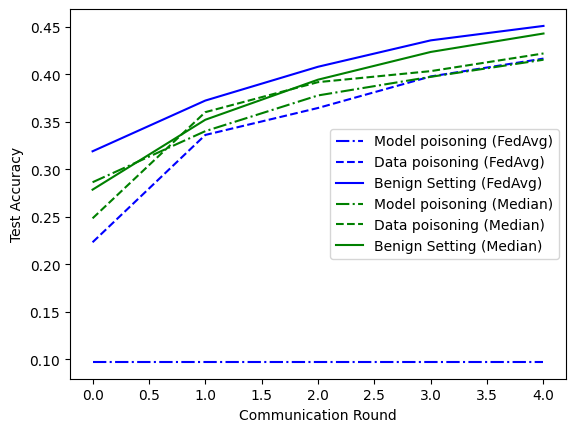

In [14]:
# Helping function
poisoned_accuracy = data_poison_results.metrics_distributed["accuracy"]
clean_accuracy = clean_results.metrics_distributed["accuracy"]
model_poison_accuracy = model_poison_results.metrics_distributed["accuracy"]

median_poisoned_accuracy = median_data_poison_results.metrics_distributed["accuracy"]
median_model_poisoned_accuracy = median_model_poison_results.metrics_distributed["accuracy"]
median_clean_accuracy = median_clean_results.metrics_distributed["accuracy"]



x= [i for i in range(NUM_ROUND)]
plt.plot(x,[model_poison_accuracy[i][1] for i in range(NUM_ROUND)], label="Model poisoning (FedAvg)" , color="blue", ls = "-.")
plt.plot(x,[poisoned_accuracy[i][1] for i in range(NUM_ROUND)], label="Data poisoning (FedAvg)", color="blue", ls = "--")
plt.plot(x,[clean_accuracy[i][1] for i in range(NUM_ROUND)], label="Benign Setting (FedAvg)", color="blue")

plt.plot(x,[median_model_poisoned_accuracy[i][1] for i in range(NUM_ROUND)], label="Model poisoning (Median)" , color="green", ls = "-.")
plt.plot(x,[median_poisoned_accuracy[i][1] for i in range(NUM_ROUND)], label="Data poisoning (Median)", color="green", ls = "--")
plt.plot(x,[median_clean_accuracy[i][1] for i in range(NUM_ROUND)], label="Benign Setting (Median)", color="green")
plt.xlabel("Communication Round")
plt.ylabel("Test Accuracy")
plt.legend()

#### Q2.1: Answer the following questions in your report:
1. Does your attack work under the FL with median aggregation? Why?
2. Are there any performance drop when using median aggregation compared to mean in the benign setting?
3. What if you increase the number of malicious clients to 5? Does your attack work (i.e., changing `NUM_ADVERSARY` to 5)? Why?

##### Report

1. Eventhough there is some acuuracy drop due to the attacks, both data and model poisoning attacks do not work that well under FL with median aggregation. This is because median aggregation is much more rubust than mean aggregation. Even in the case of huge updates (poisonous or outliers), median doesn't shift, whereas mean shifs drastically. Thus, in every communication round, the updates to the parameters are same as what they would've been in the benign setting.

2. Looking at the graph above, there seems to be slight performance drop when using median aggregation compared to mean in the benign setting. However, in multiple runs or multiple communication rounds, the accuracy would more or less converge to be the same.

3. When `NUM_ADVERSARY = 5`, i.e., 50% of the clients are malicious, both data and model poisoning attacks work. In both the cases, the poisonous updates to the parameters are due to 50% of the clients. Thus, this shifts the median of all the clients' parameters significantly. Therefore, it is possible that in many communication rounds, the true parameter updates are treated as outliers and updation happens in the direction of poisonous parameters.

### Adaptive Attack

#### Q2.2: Design your adaptive attack
Suppose the adversary can control only 4 clients out of 10 and knows that the server will apply median aggregation to filter out malicious updates. Can you design an adaptive attack?

In [15]:
NUM_ADVERSARY = 4
ADVERSARY_CID = [i for i in range(NUM_ADVERSARY)] # define the client index for malicious clients

In [21]:
import scipy.stats as st

def adaptive_train_poisoning_models(net, trainloader, epochs: int):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters())
    net.train()
    ## TODO: Model Poisoning attack ##

    n = NUM_CLIENTS
    m = NUM_ADVERSARY

    s = np.floor(n/2 + 1) - m
    ratio = (n-m-s)/(n-m)
    z_max = st.norm.ppf(ratio)

    state_dict = net.state_dict()
    for name, param in state_dict.items():
      if "weight" not in name:
        continue

      # Param shape =
      # torch.Size([6, 3, 5, 5]),
      # torch.Size([120, 400]),
      # torch.Size([84, 120]),
      # torch.Size([10, 84])

      # print(param.shape)
      dims = list(param.shape)
      if len(dims) == 4:
        var, mean = torch.var_mean(param.cpu(), dim=2, keepdim=True)
        param_j = mean - z_max * np.sqrt(var)
        param_mal = param_j.repeat(1, 1, dims[2], 1)
      else:
        var, mean = torch.var_mean(param.cpu(), dim=1, keepdim=True)
        param_j = mean - z_max * np.sqrt(var)
        param_mal = param_j.repeat(1, dims[1])

      param.copy_(param_mal.to(DEVICE))

    ##################################

class AdaptiveModelPoisonClient(BaseFlowerClient):
    def fit(self, parameters, config):
        """Fit the model using the poisoned training method."""
        print(f"[Poisoning Client {self.cid}] fit, config: {config}")
        set_parameters(self.net, parameters)
        adaptive_train_poisoning_models(self.net, self.trainloader, epochs=LOCAL_EPOCH)
        return get_parameters(self.net), len(self.trainloader), {}


def adaptive_client_fn(cid) -> FlowerClient:
    net = Net().to(DEVICE)
    trainloader = trainloaders[int(cid)]
    valloader = valloaders[int(cid)]
    if int(cid) in ADVERSARY_CID:  # if the client is an adversary
        return AdaptiveModelPoisonClient(cid, net, trainloader, valloader)
    return FlowerClient(cid, net, trainloader, valloader)


median_adaptive_model_poison_results = fl.simulation.start_simulation(
    client_fn=adaptive_client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=NUM_ROUND),  # Just three rounds
    strategy=median_strategy,
    client_resources=client_resources,
)

INFO flwr 2023-11-29 10:18:19,545 | app.py:178 | Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)
2023-11-29 10:18:25,066	INFO worker.py:1621 -- Started a local Ray instance.
INFO flwr 2023-11-29 10:18:27,726 | app.py:213 | Flower VCE: Ray initialized with resources: {'GPU': 1.0, 'node:172.28.0.12': 1.0, 'object_store_memory': 3931962163.0, 'node:__internal_head__': 1.0, 'CPU': 2.0, 'memory': 7863924327.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'GPU': 1.0, 'node:172.28.0.12': 1.0, 'object_store_memory': 3931962163.0, 'node:__internal_head__': 1.0, 'CPU': 2.0, 'memory': 7863924327.0}
INFO flwr 2023-11-29 10:18:27,740 | app.py:219 | Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
INFO:flwr:Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html


(DefaultActor pid=12563) [Client 8] get_parameters
(DefaultActor pid=12563) [Poisoning Client 0] fit, config: {}
(DefaultActor pid=12563) [Client 9] fit, config: {}
(DefaultActor pid=12563) Epoch 1: train loss 0.0637141689658165, accuracy 0.24933333333333332
(DefaultActor pid=12563) [Client 8] fit, config: {}
(DefaultActor pid=12563) Epoch 1: train loss 0.06326887756586075, accuracy 0.2531111111111111
(DefaultActor pid=12563) [Client 4] fit, config: {}
(DefaultActor pid=12563) Epoch 1: train loss 0.06434565782546997, accuracy 0.2328888888888889
(DefaultActor pid=12563) [Client 7] fit, config: {}
(DefaultActor pid=12563) Epoch 1: train loss 0.06301471590995789, accuracy 0.25
(DefaultActor pid=12563) [Client 6] fit, config: {}
(DefaultActor pid=12563) Epoch 1: train loss 0.06370934098958969, accuracy 0.24
(DefaultActor pid=12563) [Client 5] fit, config: {}
(DefaultActor pid=12563) Epoch 1: train loss 0.0644533634185791, accuracy 0.22844444444444445
(DefaultActor pid=12563) [Poisoning Cli

DEBUG flwr 2023-11-29 10:18:59,246 | server.py:236 | fit_round 1 received 10 results and 0 failures
DEBUG:flwr:fit_round 1 received 10 results and 0 failures


(DefaultActor pid=12563) [Poisoning Client 1] fit, config: {}


DEBUG flwr 2023-11-29 10:18:59,285 | server.py:173 | evaluate_round 1: strategy sampled 10 clients (out of 10)
DEBUG:flwr:evaluate_round 1: strategy sampled 10 clients (out of 10)


(DefaultActor pid=12563) [Poisoning Client 3] fit, config: {}
(DefaultActor pid=12563) [Client 8] evaluate, config: {}
(DefaultActor pid=12563) [Client 9] evaluate, config: {}
(DefaultActor pid=12563) [Client 4] evaluate, config: {}
(DefaultActor pid=12563) [Client 0] evaluate, config: {}
(DefaultActor pid=12563) [Client 7] evaluate, config: {}
(DefaultActor pid=12563) [Client 3] evaluate, config: {}
(DefaultActor pid=12563) [Client 1] evaluate, config: {}
(DefaultActor pid=12563) [Client 5] evaluate, config: {}
(DefaultActor pid=12563) [Client 6] evaluate, config: {}


DEBUG flwr 2023-11-29 10:19:15,095 | server.py:187 | evaluate_round 1 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 1 received 10 results and 0 failures
DEBUG flwr 2023-11-29 10:19:15,098 | server.py:222 | fit_round 2: strategy sampled 10 clients (out of 10)
DEBUG:flwr:fit_round 2: strategy sampled 10 clients (out of 10)


(DefaultActor pid=12563) [Client 2] evaluate, config: {}
(DefaultActor pid=12563) [Poisoning Client 3] fit, config: {}
(DefaultActor pid=12563) [Client 8] fit, config: {}
(DefaultActor pid=12563) Epoch 1: train loss 0.05778122320771217, accuracy 0.326
(DefaultActor pid=12563) [Client 4] fit, config: {}
(DefaultActor pid=12563) Epoch 1: train loss 0.05770958960056305, accuracy 0.3184444444444444
(DefaultActor pid=12563) [Poisoning Client 0] fit, config: {}
(DefaultActor pid=12563) [Client 7] fit, config: {}
(DefaultActor pid=12563) Epoch 1: train loss 0.05674393102526665, accuracy 0.3288888888888889
(DefaultActor pid=12563) [Client 9] fit, config: {}
(DefaultActor pid=12563) Epoch 1: train loss 0.05820998176932335, accuracy 0.314
(DefaultActor pid=12563) [Poisoning Client 2] fit, config: {}
(DefaultActor pid=12563) [Client 6] fit, config: {}
(DefaultActor pid=12563) Epoch 1: train loss 0.058447111397981644, accuracy 0.31244444444444447
(DefaultActor pid=12563) [Poisoning Client 1] fit, 

DEBUG flwr 2023-11-29 10:19:37,905 | server.py:236 | fit_round 2 received 10 results and 0 failures
DEBUG:flwr:fit_round 2 received 10 results and 0 failures
DEBUG flwr 2023-11-29 10:19:37,938 | server.py:173 | evaluate_round 2: strategy sampled 10 clients (out of 10)
DEBUG:flwr:evaluate_round 2: strategy sampled 10 clients (out of 10)


(DefaultActor pid=12563) Epoch 1: train loss 0.058022551238536835, accuracy 0.32422222222222224
(DefaultActor pid=12563) [Client 8] evaluate, config: {}
(DefaultActor pid=12563) [Client 2] evaluate, config: {}
(DefaultActor pid=12563) [Client 7] evaluate, config: {}
(DefaultActor pid=12563) [Client 6] evaluate, config: {}
(DefaultActor pid=12563) [Client 0] evaluate, config: {}
(DefaultActor pid=12563) [Client 9] evaluate, config: {}
(DefaultActor pid=12563) [Client 1] evaluate, config: {}
(DefaultActor pid=12563) [Client 4] evaluate, config: {}
(DefaultActor pid=12563) [Client 5] evaluate, config: {}


DEBUG flwr 2023-11-29 10:19:53,794 | server.py:187 | evaluate_round 2 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 2 received 10 results and 0 failures
DEBUG flwr 2023-11-29 10:19:53,798 | server.py:222 | fit_round 3: strategy sampled 10 clients (out of 10)
DEBUG:flwr:fit_round 3: strategy sampled 10 clients (out of 10)


(DefaultActor pid=12563) [Client 3] evaluate, config: {}
(DefaultActor pid=12563) [Client 8] fit, config: {}
(DefaultActor pid=12563) Epoch 1: train loss 0.053353581577539444, accuracy 0.37133333333333335
(DefaultActor pid=12563) [Poisoning Client 0] fit, config: {}
(DefaultActor pid=12563) [Client 6] fit, config: {}
(DefaultActor pid=12563) Epoch 1: train loss 0.0550675205886364, accuracy 0.3486666666666667
(DefaultActor pid=12563) [Client 5] fit, config: {}
(DefaultActor pid=12563) Epoch 1: train loss 0.053887989372015, accuracy 0.36777777777777776
(DefaultActor pid=12563) [Client 7] fit, config: {}
(DefaultActor pid=12563) Epoch 1: train loss 0.05284660682082176, accuracy 0.37244444444444447
(DefaultActor pid=12563) [Client 4] fit, config: {}
(DefaultActor pid=12563) Epoch 1: train loss 0.05365242063999176, accuracy 0.35844444444444445
(DefaultActor pid=12563) [Poisoning Client 1] fit, config: {}
(DefaultActor pid=12563) [Client 9] fit, config: {}
(DefaultActor pid=12563) Epoch 1: t

DEBUG flwr 2023-11-29 10:20:17,836 | server.py:236 | fit_round 3 received 10 results and 0 failures
DEBUG:flwr:fit_round 3 received 10 results and 0 failures


(DefaultActor pid=12563) [Poisoning Client 3] fit, config: {}


DEBUG flwr 2023-11-29 10:20:17,883 | server.py:173 | evaluate_round 3: strategy sampled 10 clients (out of 10)
DEBUG:flwr:evaluate_round 3: strategy sampled 10 clients (out of 10)


(DefaultActor pid=12563) [Poisoning Client 2] fit, config: {}
(DefaultActor pid=12563) [Client 9] evaluate, config: {}
(DefaultActor pid=12563) [Client 5] evaluate, config: {}
(DefaultActor pid=12563) [Client 8] evaluate, config: {}
(DefaultActor pid=12563) [Client 4] evaluate, config: {}
(DefaultActor pid=12563) [Client 7] evaluate, config: {}
(DefaultActor pid=12563) [Client 1] evaluate, config: {}
(DefaultActor pid=12563) [Client 0] evaluate, config: {}
(DefaultActor pid=12563) [Client 6] evaluate, config: {}
(DefaultActor pid=12563) [Client 2] evaluate, config: {}


DEBUG flwr 2023-11-29 10:20:33,734 | server.py:187 | evaluate_round 3 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 3 received 10 results and 0 failures
DEBUG flwr 2023-11-29 10:20:33,739 | server.py:222 | fit_round 4: strategy sampled 10 clients (out of 10)
DEBUG:flwr:fit_round 4: strategy sampled 10 clients (out of 10)


(DefaultActor pid=12563) [Client 3] evaluate, config: {}
(DefaultActor pid=12563) [Poisoning Client 2] fit, config: {}
(DefaultActor pid=12563) [Client 7] fit, config: {}
(DefaultActor pid=12563) Epoch 1: train loss 0.05127711221575737, accuracy 0.3868888888888889
(DefaultActor pid=12563) [Client 8] fit, config: {}
(DefaultActor pid=12563) Epoch 1: train loss 0.051121775060892105, accuracy 0.396
(DefaultActor pid=12563) [Client 9] fit, config: {}
(DefaultActor pid=12563) Epoch 1: train loss 0.05234724283218384, accuracy 0.3828888888888889
(DefaultActor pid=12563) [Poisoning Client 3] fit, config: {}
(DefaultActor pid=12563) [Client 5] fit, config: {}
(DefaultActor pid=12563) Epoch 1: train loss 0.0524979792535305, accuracy 0.3788888888888889
(DefaultActor pid=12563) [Poisoning Client 1] fit, config: {}
(DefaultActor pid=12563) [Client 4] fit, config: {}
(DefaultActor pid=12563) Epoch 1: train loss 0.052109524607658386, accuracy 0.39155555555555555
(DefaultActor pid=12563) [Poisoning Cl

DEBUG flwr 2023-11-29 10:20:57,389 | server.py:236 | fit_round 4 received 10 results and 0 failures
DEBUG:flwr:fit_round 4 received 10 results and 0 failures
DEBUG flwr 2023-11-29 10:20:57,443 | server.py:173 | evaluate_round 4: strategy sampled 10 clients (out of 10)
DEBUG:flwr:evaluate_round 4: strategy sampled 10 clients (out of 10)


(DefaultActor pid=12563) Epoch 1: train loss 0.05314812809228897, accuracy 0.37466666666666665
(DefaultActor pid=12563) [Client 9] evaluate, config: {}
(DefaultActor pid=12563) [Client 8] evaluate, config: {}
(DefaultActor pid=12563) [Client 3] evaluate, config: {}
(DefaultActor pid=12563) [Client 6] evaluate, config: {}
(DefaultActor pid=12563) [Client 4] evaluate, config: {}
(DefaultActor pid=12563) [Client 0] evaluate, config: {}
(DefaultActor pid=12563) [Client 7] evaluate, config: {}
(DefaultActor pid=12563) [Client 5] evaluate, config: {}
(DefaultActor pid=12563) [Client 2] evaluate, config: {}


DEBUG flwr 2023-11-29 10:21:13,464 | server.py:187 | evaluate_round 4 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 4 received 10 results and 0 failures
DEBUG flwr 2023-11-29 10:21:13,470 | server.py:222 | fit_round 5: strategy sampled 10 clients (out of 10)
DEBUG:flwr:fit_round 5: strategy sampled 10 clients (out of 10)


(DefaultActor pid=12563) [Client 1] evaluate, config: {}
(DefaultActor pid=12563) [Client 5] fit, config: {}
(DefaultActor pid=12563) Epoch 1: train loss 0.05096718668937683, accuracy 0.40555555555555556
(DefaultActor pid=12563) [Client 7] fit, config: {}
(DefaultActor pid=12563) Epoch 1: train loss 0.04998496174812317, accuracy 0.4073333333333333
(DefaultActor pid=12563) [Poisoning Client 1] fit, config: {}
(DefaultActor pid=12563) [Client 6] fit, config: {}
(DefaultActor pid=12563) Epoch 1: train loss 0.051467981189489365, accuracy 0.39866666666666667
(DefaultActor pid=12563) [Client 9] fit, config: {}
(DefaultActor pid=12563) Epoch 1: train loss 0.05088282749056816, accuracy 0.39711111111111114
(DefaultActor pid=12563) [Client 8] fit, config: {}
(DefaultActor pid=12563) Epoch 1: train loss 0.050063032656908035, accuracy 0.4088888888888889
(DefaultActor pid=12563) [Poisoning Client 2] fit, config: {}
(DefaultActor pid=12563) [Poisoning Client 3] fit, config: {}
(DefaultActor pid=1256

DEBUG flwr 2023-11-29 10:21:36,103 | server.py:236 | fit_round 5 received 10 results and 0 failures
DEBUG:flwr:fit_round 5 received 10 results and 0 failures
DEBUG flwr 2023-11-29 10:21:36,143 | server.py:173 | evaluate_round 5: strategy sampled 10 clients (out of 10)
DEBUG:flwr:evaluate_round 5: strategy sampled 10 clients (out of 10)


(DefaultActor pid=12563) Epoch 1: train loss 0.05060907453298569, accuracy 0.4088888888888889
(DefaultActor pid=12563) [Client 6] evaluate, config: {}
(DefaultActor pid=12563) [Client 9] evaluate, config: {}
(DefaultActor pid=12563) [Client 7] evaluate, config: {}
(DefaultActor pid=12563) [Client 8] evaluate, config: {}
(DefaultActor pid=12563) [Client 2] evaluate, config: {}
(DefaultActor pid=12563) [Client 5] evaluate, config: {}
(DefaultActor pid=12563) [Client 1] evaluate, config: {}
(DefaultActor pid=12563) [Client 4] evaluate, config: {}
(DefaultActor pid=12563) [Client 3] evaluate, config: {}


DEBUG flwr 2023-11-29 10:21:52,393 | server.py:187 | evaluate_round 5 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 5 received 10 results and 0 failures
INFO flwr 2023-11-29 10:21:52,398 | server.py:153 | FL finished in 197.91097190400023
INFO:flwr:FL finished in 197.91097190400023
INFO flwr 2023-11-29 10:21:52,403 | app.py:226 | app_fit: losses_distributed [(1, 0.06738978586196899), (2, 0.05789067294597626), (3, 0.05459935140609741), (4, 0.053322576951980595), (5, 0.05219246354103089)]
INFO:flwr:app_fit: losses_distributed [(1, 0.06738978586196899), (2, 0.05789067294597626), (3, 0.05459935140609741), (4, 0.053322576951980595), (5, 0.05219246354103089)]
INFO flwr 2023-11-29 10:21:52,405 | app.py:227 | app_fit: metrics_distributed_fit {}
INFO:flwr:app_fit: metrics_distributed_fit {}
INFO flwr 2023-11-29 10:21:52,408 | app.py:228 | app_fit: metrics_distributed {'accuracy': [(1, 0.27619999999999995), (2, 0.3342), (3, 0.38039999999999996), (4, 0.39980000000000004), (5, 0.404

(DefaultActor pid=12563) [Client 0] evaluate, config: {}


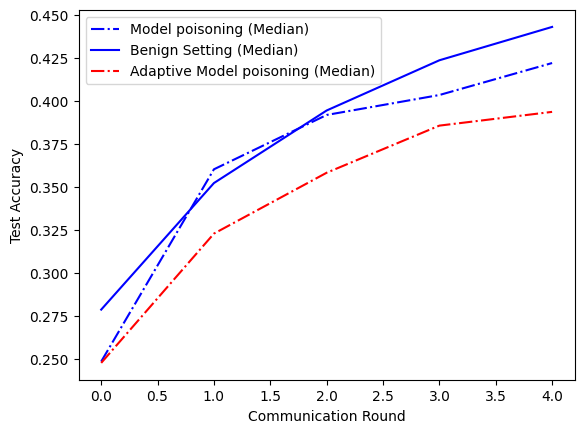

In [17]:
# Helping function

median_adaptive_model_poison = median_adaptive_model_poison_results.metrics_distributed["accuracy"]

x = [i for i in range(NUM_ROUND)]
plt.plot(
    x,
    [median_poisoned_accuracy[i][1] for i in range(NUM_ROUND)],
    label="Model poisoning (Median)",
    color="blue",
    ls='-.'
)
plt.plot(
    x,
    [median_clean_accuracy[i][1] for i in range(NUM_ROUND)],
    label="Benign Setting (Median)",
    color="blue",
)

plt.plot(
    x,
    [median_adaptive_model_poison[i][1] for i in range(NUM_ROUND)],
    label="Adaptive Model poisoning (Median)",
    color="red",
    ls='-.'
)
plt.xlabel("Communication Round")
plt.ylabel("Test Accuracy")
plt.legend()

#### Q2.3: Answer the following questions in your report:
1. Please explain your attack design and the rationale behind it

#### Report

The attack design is based on [1].

- Statistical defense mechanisms are designed to discard values that are too far away from the mean. We thus seek a range in which we can deviate from the mean without being detected. Since normal distribution is symmetric, the same value $z_{max}$ will set the lower and upper bounds for the applicable changes around the mean.

- In order to change the value produced by the aggregation rule, the attacker should control a majority of the workers. The attacker can attain this majority by finding the minimal number $s$ of non-corrupted workers that are required as “supporters”.

- The attacker will then use properties of the Cumulative Standard Normal Function $\phi(z)$, and look for the maximal value $z_{max}$ such that $s$ non-corrupted workers will reside farther away from the mean, hence preferring the selection of the poisonous parameters instead of the more distant correct mean.

- By setting all corrupted workers to values in the range $(\mu - z_{max}*\sigma, \mu + z_{max}*\sigma)$, the defenses will not be able to differentiate the corrupted workers from the benign.

This attack works for the following reason:

- Most existing defenses for distributed learning work under the assumption that changes which are upper-bounded by an order of the variance of the correct workers cannot satisfy a malicious objective. Given this last assumption, those defenses use statistics-based methods to clear away the large changes and prevent attacks.

- However, the experimental variance between the different workers is high enough so that by carefully crafting byzantine values that are as far as possible from the correct ones, yet within the bounds of existing defenses, we are capable of gaining control over the training process.

- The high variance even on simple deep learning tasks, along with the high skewness induced by putting all the Byzantine workers on the same side in our attack is enough for the attacker to hide Byzantine workers within the variance of the correct workers, and still gain control over the training process.


#### References:

[1] Gilad Baruch, Moran Baruch, and Yoav Goldberg. A little is enough: Circumvent- ing defenses for distributed learning. Advances in Neural Information Processing Systems, 32, 2019.

**NOTE: My initial model poisoning attack also works well with `NUM_ADVERSARY=4`. This is because the median starts to shift away significantly from the true median with increasing corrupted clients. Please see the training and corresponding graph below.**


In [18]:
import scipy.stats as st

def adaptive_train_poisoning_models(net, trainloader, epochs: int):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters())
    net.train()
    ## TODO: Model Poisoning attack ##

    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for images, labels in trainloader:
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)

            optimizer.zero_grad()

            outputs = net(images)
            loss = -criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            epoch_loss += loss
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
        epoch_loss /= len(trainloader.dataset)
        epoch_acc = correct / total
        print(f"Epoch {epoch+1}: train loss {epoch_loss}, accuracy {epoch_acc}")

    ##################################

class AdaptiveModelPoisonClient(BaseFlowerClient):
    def fit(self, parameters, config):
        """Fit the model using the poisoned training method."""
        print(f"[Poisoning Client {self.cid}] fit, config: {config}")
        set_parameters(self.net, parameters)
        adaptive_train_poisoning_models(self.net, self.trainloader, epochs=LOCAL_EPOCH)
        return get_parameters(self.net), len(self.trainloader), {}


def adaptive_client_fn(cid) -> FlowerClient:
    net = Net().to(DEVICE)
    trainloader = trainloaders[int(cid)]
    valloader = valloaders[int(cid)]
    if int(cid) in ADVERSARY_CID:  # if the client is an adversary
        return AdaptiveModelPoisonClient(cid, net, trainloader, valloader)
    return FlowerClient(cid, net, trainloader, valloader)


median_adaptive_model_poison_results = fl.simulation.start_simulation(
    client_fn=adaptive_client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=NUM_ROUND),  # Just three rounds
    strategy=median_strategy,
    client_resources=client_resources,
)

INFO flwr 2023-11-29 10:11:42,301 | app.py:178 | Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)
2023-11-29 10:11:46,576	INFO worker.py:1621 -- Started a local Ray instance.
INFO flwr 2023-11-29 10:11:48,666 | app.py:213 | Flower VCE: Ray initialized with resources: {'memory': 7866635060.0, 'CPU': 2.0, 'object_store_memory': 3933317529.0, 'node:172.28.0.12': 1.0, 'GPU': 1.0, 'node:__internal_head__': 1.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'memory': 7866635060.0, 'CPU': 2.0, 'object_store_memory': 3933317529.0, 'node:172.28.0.12': 1.0, 'GPU': 1.0, 'node:__internal_head__': 1.0}
INFO flwr 2023-11-29 10:11:48,673 | app.py:219 | Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
INFO:flwr:Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html


(DefaultActor pid=10416) [Client 3] get_parameters
(DefaultActor pid=10416) [Client 6] fit, config: {}
(DefaultActor pid=10416) Epoch 1: train loss 0.06492426991462708, accuracy 0.21888888888888888
(DefaultActor pid=10416) [Client 8] fit, config: {}
(DefaultActor pid=10416) Epoch 1: train loss 0.06388963013887405, accuracy 0.2291111111111111
(DefaultActor pid=10416) [Client 5] fit, config: {}
(DefaultActor pid=10416) Epoch 1: train loss 0.06524383276700974, accuracy 0.21733333333333332
(DefaultActor pid=10416) [Client 4] fit, config: {}
(DefaultActor pid=10416) Epoch 1: train loss 0.06434666365385056, accuracy 0.21488888888888888
(DefaultActor pid=10416) [Poisoning Client 1] fit, config: {}
(DefaultActor pid=10416) Epoch 1: train loss -9976.955078125, accuracy 0.09533333333333334
(DefaultActor pid=10416) [Poisoning Client 0] fit, config: {}
(DefaultActor pid=10416) Epoch 1: train loss -9403.4853515625, accuracy 0.09977777777777778
(DefaultActor pid=10416) [Poisoning Client 3] fit, conf

DEBUG flwr 2023-11-29 10:12:27,438 | server.py:236 | fit_round 1 received 10 results and 0 failures
DEBUG:flwr:fit_round 1 received 10 results and 0 failures
DEBUG flwr 2023-11-29 10:12:27,488 | server.py:173 | evaluate_round 1: strategy sampled 10 clients (out of 10)
DEBUG:flwr:evaluate_round 1: strategy sampled 10 clients (out of 10)


(DefaultActor pid=10416) Epoch 1: train loss -9749.3486328125, accuracy 0.09977777777777778
(DefaultActor pid=10416) [Client 1] evaluate, config: {}
(DefaultActor pid=10416) [Client 8] evaluate, config: {}
(DefaultActor pid=10416) [Client 6] evaluate, config: {}
(DefaultActor pid=10416) [Client 5] evaluate, config: {}
(DefaultActor pid=10416) [Client 2] evaluate, config: {}
(DefaultActor pid=10416) [Client 3] evaluate, config: {}
(DefaultActor pid=10416) [Client 7] evaluate, config: {}
(DefaultActor pid=10416) [Client 0] evaluate, config: {}
(DefaultActor pid=10416) [Client 4] evaluate, config: {}


DEBUG flwr 2023-11-29 10:12:43,329 | server.py:187 | evaluate_round 1 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 1 received 10 results and 0 failures
DEBUG flwr 2023-11-29 10:12:43,334 | server.py:222 | fit_round 2: strategy sampled 10 clients (out of 10)
DEBUG:flwr:fit_round 2: strategy sampled 10 clients (out of 10)


(DefaultActor pid=10416) [Client 9] evaluate, config: {}
(DefaultActor pid=10416) [Client 6] fit, config: {}
(DefaultActor pid=10416) Epoch 1: train loss 0.06177370250225067, accuracy 0.27644444444444444
(DefaultActor pid=10416) [Poisoning Client 3] fit, config: {}
(DefaultActor pid=10416) Epoch 1: train loss -19919.001953125, accuracy 0.10511111111111111
(DefaultActor pid=10416) [Poisoning Client 2] fit, config: {}
(DefaultActor pid=10416) Epoch 1: train loss -21203.900390625, accuracy 0.10555555555555556
(DefaultActor pid=10416) [Poisoning Client 0] fit, config: {}
(DefaultActor pid=10416) Epoch 1: train loss -20449.73828125, accuracy 0.10533333333333333
(DefaultActor pid=10416) [Client 5] fit, config: {}
(DefaultActor pid=10416) Epoch 1: train loss 0.06157602369785309, accuracy 0.2817777777777778
(DefaultActor pid=10416) [Client 8] fit, config: {}
(DefaultActor pid=10416) Epoch 1: train loss 0.059934671968221664, accuracy 0.3002222222222222
(DefaultActor pid=10416) [Poisoning Client

DEBUG flwr 2023-11-29 10:13:12,169 | server.py:236 | fit_round 2 received 10 results and 0 failures
DEBUG:flwr:fit_round 2 received 10 results and 0 failures
DEBUG flwr 2023-11-29 10:13:12,221 | server.py:173 | evaluate_round 2: strategy sampled 10 clients (out of 10)
DEBUG:flwr:evaluate_round 2: strategy sampled 10 clients (out of 10)


(DefaultActor pid=10416) Epoch 1: train loss 0.0606212317943573, accuracy 0.29444444444444445
(DefaultActor pid=10416) [Client 2] evaluate, config: {}
(DefaultActor pid=10416) [Client 8] evaluate, config: {}
(DefaultActor pid=10416) [Client 4] evaluate, config: {}
(DefaultActor pid=10416) [Client 6] evaluate, config: {}
(DefaultActor pid=10416) [Client 0] evaluate, config: {}
(DefaultActor pid=10416) [Client 1] evaluate, config: {}
(DefaultActor pid=10416) [Client 5] evaluate, config: {}
(DefaultActor pid=10416) [Client 7] evaluate, config: {}
(DefaultActor pid=10416) [Client 9] evaluate, config: {}


DEBUG flwr 2023-11-29 10:13:29,084 | server.py:187 | evaluate_round 2 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 2 received 10 results and 0 failures
DEBUG flwr 2023-11-29 10:13:29,089 | server.py:222 | fit_round 3: strategy sampled 10 clients (out of 10)
DEBUG:flwr:fit_round 3: strategy sampled 10 clients (out of 10)


(DefaultActor pid=10416) [Client 3] evaluate, config: {}
(DefaultActor pid=10416) [Poisoning Client 1] fit, config: {}
(DefaultActor pid=10416) Epoch 1: train loss -15489.7099609375, accuracy 0.09933333333333333
(DefaultActor pid=10416) [Client 9] fit, config: {}
(DefaultActor pid=10416) Epoch 1: train loss 0.055970534682273865, accuracy 0.3382222222222222
(DefaultActor pid=10416) [Client 7] fit, config: {}
(DefaultActor pid=10416) Epoch 1: train loss 0.05534297227859497, accuracy 0.3353333333333333
(DefaultActor pid=10416) [Client 6] fit, config: {}
(DefaultActor pid=10416) Epoch 1: train loss 0.056924548000097275, accuracy 0.326
(DefaultActor pid=10416) [Poisoning Client 2] fit, config: {}
(DefaultActor pid=10416) Epoch 1: train loss -18864.720703125, accuracy 0.10822222222222222
(DefaultActor pid=10416) [Client 8] fit, config: {}
(DefaultActor pid=10416) Epoch 1: train loss 0.05506357178092003, accuracy 0.3546666666666667
(DefaultActor pid=10416) [Poisoning Client 0] fit, config: {}

DEBUG flwr 2023-11-29 10:13:58,073 | server.py:236 | fit_round 3 received 10 results and 0 failures
DEBUG:flwr:fit_round 3 received 10 results and 0 failures
DEBUG flwr 2023-11-29 10:13:58,110 | server.py:173 | evaluate_round 3: strategy sampled 10 clients (out of 10)
DEBUG:flwr:evaluate_round 3: strategy sampled 10 clients (out of 10)


(DefaultActor pid=10416) Epoch 1: train loss 0.055353663861751556, accuracy 0.3531111111111111
(DefaultActor pid=10416) [Client 7] evaluate, config: {}
(DefaultActor pid=10416) [Client 0] evaluate, config: {}
(DefaultActor pid=10416) [Client 1] evaluate, config: {}
(DefaultActor pid=10416) [Client 8] evaluate, config: {}
(DefaultActor pid=10416) [Client 3] evaluate, config: {}
(DefaultActor pid=10416) [Client 2] evaluate, config: {}
(DefaultActor pid=10416) [Client 9] evaluate, config: {}
(DefaultActor pid=10416) [Client 5] evaluate, config: {}
(DefaultActor pid=10416) [Client 6] evaluate, config: {}


DEBUG flwr 2023-11-29 10:14:13,748 | server.py:187 | evaluate_round 3 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 3 received 10 results and 0 failures
DEBUG flwr 2023-11-29 10:14:13,751 | server.py:222 | fit_round 4: strategy sampled 10 clients (out of 10)
DEBUG:flwr:fit_round 4: strategy sampled 10 clients (out of 10)


(DefaultActor pid=10416) [Client 4] evaluate, config: {}
(DefaultActor pid=10416) [Poisoning Client 2] fit, config: {}
(DefaultActor pid=10416) Epoch 1: train loss -21957.810546875, accuracy 0.10622222222222222
(DefaultActor pid=10416) [Poisoning Client 1] fit, config: {}
(DefaultActor pid=10416) Epoch 1: train loss -21524.296875, accuracy 0.09911111111111111
(DefaultActor pid=10416) [Client 6] fit, config: {}
(DefaultActor pid=10416) Epoch 1: train loss 0.05449918657541275, accuracy 0.3622222222222222
(DefaultActor pid=10416) [Client 7] fit, config: {}
(DefaultActor pid=10416) Epoch 1: train loss 0.05320683494210243, accuracy 0.3662222222222222
(DefaultActor pid=10416) [Client 5] fit, config: {}
(DefaultActor pid=10416) Epoch 1: train loss 0.05409012734889984, accuracy 0.37177777777777776
(DefaultActor pid=10416) [Client 4] fit, config: {}
(DefaultActor pid=10416) Epoch 1: train loss 0.053521350026130676, accuracy 0.37822222222222224
(DefaultActor pid=10416) [Client 9] fit, config: {}

DEBUG flwr 2023-11-29 10:14:42,677 | server.py:236 | fit_round 4 received 10 results and 0 failures
DEBUG:flwr:fit_round 4 received 10 results and 0 failures
DEBUG flwr 2023-11-29 10:14:42,714 | server.py:173 | evaluate_round 4: strategy sampled 10 clients (out of 10)
DEBUG:flwr:evaluate_round 4: strategy sampled 10 clients (out of 10)


(DefaultActor pid=10416) Epoch 1: train loss 0.05302799865603447, accuracy 0.37444444444444447
(DefaultActor pid=10416) [Client 9] evaluate, config: {}
(DefaultActor pid=10416) [Client 0] evaluate, config: {}
(DefaultActor pid=10416) [Client 3] evaluate, config: {}
(DefaultActor pid=10416) [Client 2] evaluate, config: {}
(DefaultActor pid=10416) [Client 6] evaluate, config: {}
(DefaultActor pid=10416) [Client 4] evaluate, config: {}
(DefaultActor pid=10416) [Client 1] evaluate, config: {}
(DefaultActor pid=10416) [Client 7] evaluate, config: {}
(DefaultActor pid=10416) [Client 5] evaluate, config: {}


DEBUG flwr 2023-11-29 10:14:58,610 | server.py:187 | evaluate_round 4 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 4 received 10 results and 0 failures
DEBUG flwr 2023-11-29 10:14:58,615 | server.py:222 | fit_round 5: strategy sampled 10 clients (out of 10)
DEBUG:flwr:fit_round 5: strategy sampled 10 clients (out of 10)


(DefaultActor pid=10416) [Client 8] evaluate, config: {}
(DefaultActor pid=10416) [Client 7] fit, config: {}
(DefaultActor pid=10416) Epoch 1: train loss 0.050515711307525635, accuracy 0.40244444444444444
(DefaultActor pid=10416) [Poisoning Client 1] fit, config: {}
(DefaultActor pid=10416) Epoch 1: train loss -18549.91015625, accuracy 0.10088888888888889
(DefaultActor pid=10416) [Client 4] fit, config: {}
(DefaultActor pid=10416) Epoch 1: train loss 0.05142214894294739, accuracy 0.3917777777777778
(DefaultActor pid=10416) [Client 8] fit, config: {}
(DefaultActor pid=10416) Epoch 1: train loss 0.05071590468287468, accuracy 0.4037777777777778
(DefaultActor pid=10416) [Client 5] fit, config: {}
(DefaultActor pid=10416) Epoch 1: train loss 0.052167270332574844, accuracy 0.38422222222222224
(DefaultActor pid=10416) [Client 9] fit, config: {}
(DefaultActor pid=10416) Epoch 1: train loss 0.05172962322831154, accuracy 0.40044444444444444
(DefaultActor pid=10416) [Poisoning Client 0] fit, conf

DEBUG flwr 2023-11-29 10:15:27,938 | server.py:236 | fit_round 5 received 10 results and 0 failures
DEBUG:flwr:fit_round 5 received 10 results and 0 failures
DEBUG flwr 2023-11-29 10:15:27,973 | server.py:173 | evaluate_round 5: strategy sampled 10 clients (out of 10)
DEBUG:flwr:evaluate_round 5: strategy sampled 10 clients (out of 10)


(DefaultActor pid=10416) Epoch 1: train loss 0.05262155830860138, accuracy 0.37955555555555553
(DefaultActor pid=10416) [Client 7] evaluate, config: {}
(DefaultActor pid=10416) [Client 4] evaluate, config: {}
(DefaultActor pid=10416) [Client 2] evaluate, config: {}
(DefaultActor pid=10416) [Client 8] evaluate, config: {}
(DefaultActor pid=10416) [Client 3] evaluate, config: {}
(DefaultActor pid=10416) [Client 5] evaluate, config: {}
(DefaultActor pid=10416) [Client 9] evaluate, config: {}
(DefaultActor pid=10416) [Client 0] evaluate, config: {}
(DefaultActor pid=10416) [Client 1] evaluate, config: {}


DEBUG flwr 2023-11-29 10:15:43,780 | server.py:187 | evaluate_round 5 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 5 received 10 results and 0 failures
INFO flwr 2023-11-29 10:15:43,785 | server.py:153 | FL finished in 226.34922472800008
INFO:flwr:FL finished in 226.34922472800008
INFO flwr 2023-11-29 10:15:43,788 | app.py:226 | app_fit: losses_distributed [(1, 0.13891264767646788), (2, 0.06330473651885987), (3, 0.07884159014225008), (4, 0.06347874429225922), (5, 0.07041681821346284)]
INFO:flwr:app_fit: losses_distributed [(1, 0.13891264767646788), (2, 0.06330473651885987), (3, 0.07884159014225008), (4, 0.06347874429225922), (5, 0.07041681821346284)]
INFO flwr 2023-11-29 10:15:43,790 | app.py:227 | app_fit: metrics_distributed_fit {}
INFO:flwr:app_fit: metrics_distributed_fit {}
INFO flwr 2023-11-29 10:15:43,792 | app.py:228 | app_fit: metrics_distributed {'accuracy': [(1, 0.11100000000000002), (2, 0.26960000000000006), (3, 0.2024), (4, 0.30179999999999996), (5, 0.289)]

(DefaultActor pid=10416) [Client 6] evaluate, config: {}


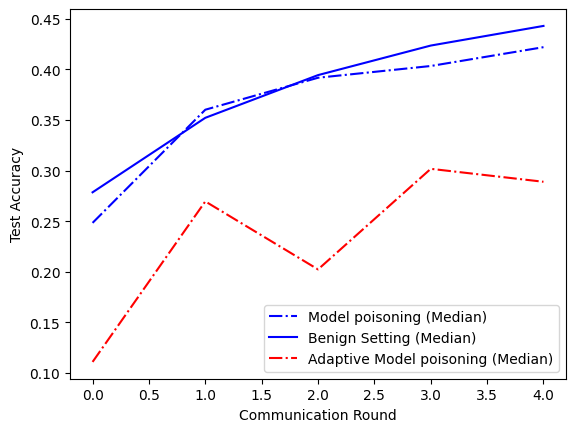

In [19]:
# Helping function

median_adaptive_model_poison = median_adaptive_model_poison_results.metrics_distributed["accuracy"]

x = [i for i in range(NUM_ROUND)]
plt.plot(
    x,
    [median_poisoned_accuracy[i][1] for i in range(NUM_ROUND)],
    label="Model poisoning (Median)",
    color="blue",
    ls='-.'
)
plt.plot(
    x,
    [median_clean_accuracy[i][1] for i in range(NUM_ROUND)],
    label="Benign Setting (Median)",
    color="blue",
)

plt.plot(
    x,
    [median_adaptive_model_poison[i][1] for i in range(NUM_ROUND)],
    label="Adaptive Model poisoning (Median)",
    color="red",
    ls='-.'
)
plt.xlabel("Communication Round")
plt.ylabel("Test Accuracy")
plt.legend()